# Домашнее задание: Классификация 128x128 + U-Net c бэкбоном


In [1]:
import os
import random
from PIL import Image
import numpy as np
import pandas as pd
from collections import Counter, defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm import tqdm

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)


## Часть 1. Классификатор 128×128

In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset

class TinyImageNetDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        """
        root_dir: путь до папки tiny-imagenet-200
        split: 'train', 'val' или 'test'
        transform: трансформации изображений
        """
        self.root_dir = root_dir
        self.split = split
        self.transform = transform

        with open(os.path.join(root_dir, 'wnids.txt'), 'r') as f:
            self.class_names = [line.strip() for line in f]
        self.class_to_idx = {name: i for i, name in enumerate(self.class_names)}

        self.samples = []
        if split == 'train':
            train_dir = os.path.join(root_dir, 'train')
            for cls in os.listdir(train_dir):
                img_dir = os.path.join(train_dir, cls, 'images')
                if not os.path.exists(img_dir):
                    continue
                for img_name in os.listdir(img_dir):
                    img_path = os.path.join(img_dir, img_name)
                    label = self.class_to_idx[cls]
                    self.samples.append((img_path, label))

        elif split == 'val':
            val_dir = os.path.join(root_dir, 'val', 'images')
            anno_path = os.path.join(root_dir, 'val', 'val_annotations.txt')

            label_map = {}
            with open(anno_path, 'r') as f:
                for line in f:
                    img_name, cls, *_ = line.strip().split('\t')
                    label_map[img_name] = cls

            for img_name in os.listdir(val_dir):
                cls = label_map.get(img_name)
                if cls:
                    img_path = os.path.join(val_dir, img_name)
                    label = self.class_to_idx[cls]
                    self.samples.append((img_path, label))

        else:
            test_dir = os.path.join(root_dir, 'test', 'images')
            for img_name in os.listdir(test_dir):
                img_path = os.path.join(test_dir, img_name)
                self.samples.append((img_path, -1))  # тест без меток

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label


train_transform = transforms.Compose([
    transforms.Resize((164, 1)),                    
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),  
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),                     
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

root = "data/tiny-imagenet-200"

train_dataset = TinyImageNetDataset(root, split='train', transform=train_transform)
val_dataset = TinyImageNetDataset(root, split='val', transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

print(f"Train size: {len(train_dataset)}")
print(f"Val size: {len(val_dataset)}")
print(f"Классов: {len(train_dataset.class_names)}")



Train size: 100000
Val size: 10000
Классов: 200


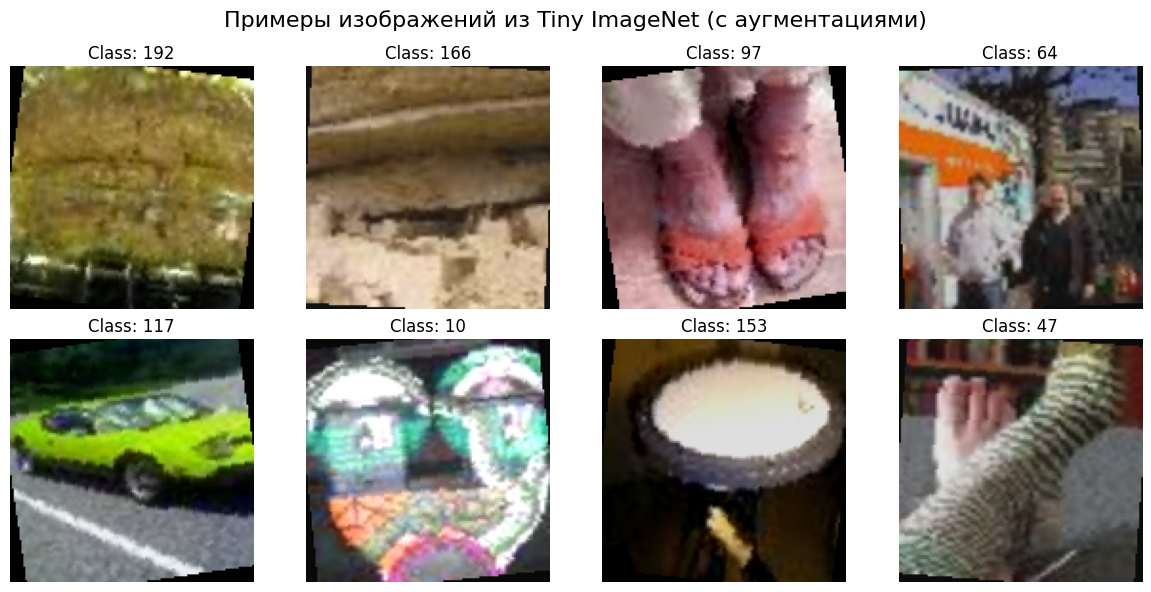

Размер батча: torch.Size([8, 3, 128, 128])
Диапазон значений: [-2.118, 2.640]
Метки классов: [192, 166, 97, 64, 117, 10, 153, 47]
Всего классов в датасете: 200
Примеры названий классов: ['n02124075', 'n04067472', 'n04540053', 'n04099969', 'n07749582']


In [3]:
images, labels = next(iter(train_loader))

def denormalize(img_tensor):
    """Вернём изображение из нормализованного диапазона в [0,1]"""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 1, 3)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 1, 3)
    img = img_tensor.permute(1, 2, 0) * std + mean
    return img.clamp(0, 1)

images_vis = images.permute(0, 2, 3, 1)

images_vis = torch.stack([denormalize(img) for img in images])

plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(images_vis[i])
    plt.title(f"Class: {labels[i].item()}")
    plt.axis('off')
plt.suptitle("Примеры изображений из Tiny ImageNet (с аугментациями)", fontsize=16)
plt.tight_layout()
plt.show()

print(f"Размер батча: {images.shape}")
print(f"Диапазон значений: [{images.min():.3f}, {images.max():.3f}]")
print(f"Метки классов: {labels.tolist()}")
print(f"Всего классов в датасете: {len(train_dataset.class_names)}")
print(f"Примеры названий классов: {train_dataset.class_names[:5]}")



In [4]:
selected_classes = [32, 27, 14, 17, 0, 11, 13, 3, 4, 8]  

subset_train_samples = [s for s in train_dataset.samples if s[1] in selected_classes]
subset_val_samples = [s for s in val_dataset.samples if s[1] in selected_classes]

print(f"Используем {len(subset_train_samples)} train и {len(subset_val_samples)} val изображений "
      f"из {len(selected_classes)} классов")

# Перенумеровка классов
class_to_new_idx = {cls: i for i, cls in enumerate(selected_classes)}

def remap_samples(samples):
    return [(path, class_to_new_idx[label]) for path, label in samples]

subset_train_samples = remap_samples(subset_train_samples)
subset_val_samples = remap_samples(subset_val_samples)


class CustomDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label


train_subset_dataset = CustomDataset(subset_train_samples, transform=train_transform)
val_subset_dataset = CustomDataset(subset_val_samples, transform=val_transform)

train_loader = DataLoader(train_subset_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset_dataset, batch_size=64, shuffle=False)

Используем 5000 train и 500 val изображений из 10 классов


In [5]:
# Заполните пропуски в BasicBlock
class BasicBlock(nn.Module):
    """
    Базовый блок ResNet с residual connection
    
    Args:
        in_channels (int): количество входных каналов
        out_channels (int): количество выходных каналов
        stride (int): шаг свертки (по умолчанию 1)
        downsample (nn.Module): слой для изменения размерности (если нужно)
    """
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = downsample
        if self.downsample is None and (in_channels != out_channels or stride != 1):
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        if (self.downsample is not None):
            identity = self.downsample(x)
        else:
            identity = x
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        out = self.relu(x + identity)

        return out

Возьмем архитектуру из предыдущего ДЗ. 
- 64 → 128 → 256 каналов (без 4-го слоя)
- [2, 2, 2] - по 2 блока в каждом слое (стандартная ResNet18)
- ELU (так как данная функция активации показала наилучший результат)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleResNet_32B(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)  
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ELU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  

        self.basic_block_1_0 = BasicBlock(64, 64)
        self.basic_block_1_1 = BasicBlock(64, 64)

        self.basic_block_2_0 = BasicBlock(64, 128, stride=2)  
        self.basic_block_2_1 = BasicBlock(128, 128)

        self.basic_block_3_0 = BasicBlock(128, 256, stride=2)  
        self.basic_block_3_1 = BasicBlock(256, 256)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  
        self.fc = nn.Linear(256, num_classes)  

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))  
        x = self.maxpool(x)  

        x = self.basic_block_1_0(x)
        x = self.basic_block_1_1(x)

        x = self.basic_block_2_0(x)
        x = self.basic_block_2_1(x)

        x = self.basic_block_3_0(x)
        x = self.basic_block_3_1(x)

        x = self.avgpool(x)

        x = torch.flatten(x, 1)

        x = self.fc(x)

        return x


model = SimpleResNet_32B(num_classes=10)  
test_input = torch.randn(1, 3, 128, 128)  

output = model(test_input)
print(output.shape)  

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Всего параметров: {total_params:,}")
print(f"Обучаемых параметров: {trainable_params:,}")


torch.Size([1, 10])
Всего параметров: 2,779,850
Обучаемых параметров: 2,779,850


In [ ]:
import torch
from tqdm import tqdm

def train_epoch(model, train_loader, optimizer, criterion, device):
  
    model.train()  # Переводим модель в режим обучения
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc="Training")  
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad() 

        output = model(data)

        loss = criterion(output, target)

        loss.backward()

        optimizer.step()

        running_loss += loss.item()

        _, predicted = output.max(1)  
        total += target.size(0)  
        correct += (predicted == target).sum().item()  

    train_loss = running_loss / len(train_loader)  
    train_acc = 100. * correct / total  
    
    return train_loss, train_acc


In [ ]:
import torch
from tqdm import tqdm

def validate_epoch(model, val_loader, criterion, device):
    """
    Функция для валидации модели
    
    Args:
        model: модель для валидации
        val_loader: DataLoader с валидационными данными
        criterion: функция потерь
        device: устройство (cpu/cuda)
    
    Returns:
        val_loss: средняя потеря на валидации
        val_acc: средняя точность на валидации
    """
    model.eval()  
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(val_loader, desc="Validation")  
    
    with torch.no_grad():  
        for batch_idx, (data, target) in enumerate(val_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)

            loss = criterion(output, target)

            running_loss += loss.item()

            _, predicted = output.max(1)  
            total += target.size(0)
            correct += (predicted == target).sum().item()

    val_loss = running_loss / len(val_loader)  
    val_acc = 100. * correct / total  
    
    return val_loss, val_acc


In [9]:
def train_model(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=20):
    """
    Основная функция для обучения модели
    
    Args:
        model: модель для обучения
        train_loader: DataLoader с тренировочными данными
        val_loader: DataLoader с валидационными данными
        optimizer: оптимизатор
        criterion: функция потерь
        device: устройство (cpu/cuda)
        num_epochs: количество эпох
    
    Returns:
        history: словарь с историей обучения
    """
    print(f"Обучение на {num_epochs} эпох...")
    
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    model = model.to(device)
    
    best_val_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f" Эпоха {epoch+1}/{num_epochs}")
        
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f" Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f" Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
            print(f" Сохранена лучшая модель с точностью {val_acc:.2f}%")
        
    
    return history, best_val_acc

In [10]:
def plot_training_history(history):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    

    ax1.plot(history['train_loss'], label='Train Loss', color='blue')
    ax1.plot(history['val_loss'], label='Validation Loss', color='red')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    ax2.plot(history['train_acc'], label='Train Accuracy', color='blue')
    ax2.plot(history['val_acc'], label='Validation Accuracy', color='red')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

In [11]:
model = SimpleResNet_32B(num_classes=len(selected_classes))

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

history, best_acc_val = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=20
)



Обучение на 20 эпох...
 Эпоха 1/20


Validation:   0%|          | 0/8 [00:09<?, ?it/s]


 Train Loss: 1.9878, Train Acc: 28.30%
 Val Loss: 1.7784, Val Acc: 38.20%
 Сохранена лучшая модель с точностью 38.20%
 Эпоха 2/20


Validation:   0%|          | 0/8 [00:09<?, ?it/s]


 Train Loss: 1.8114, Train Acc: 35.76%
 Val Loss: 1.8836, Val Acc: 37.40%
 Эпоха 3/20


Validation:   0%|          | 0/8 [00:09<?, ?it/s]


 Train Loss: 1.6988, Train Acc: 40.56%
 Val Loss: 2.1295, Val Acc: 37.40%
 Эпоха 4/20


Validation:   0%|          | 0/8 [00:09<?, ?it/s]


 Train Loss: 1.5954, Train Acc: 44.38%
 Val Loss: 1.4592, Val Acc: 51.60%
 Сохранена лучшая модель с точностью 51.60%
 Эпоха 5/20


Validation:   0%|          | 0/8 [00:09<?, ?it/s]


 Train Loss: 1.5168, Train Acc: 47.94%
 Val Loss: 2.2004, Val Acc: 31.40%
 Эпоха 6/20


Validation:   0%|          | 0/8 [00:10<?, ?it/s]


 Train Loss: 1.4712, Train Acc: 49.52%
 Val Loss: 1.5974, Val Acc: 45.80%
 Эпоха 7/20


Validation:   0%|          | 0/8 [00:10<?, ?it/s]


 Train Loss: 1.3817, Train Acc: 53.20%
 Val Loss: 1.2342, Val Acc: 59.00%
 Сохранена лучшая модель с точностью 59.00%
 Эпоха 8/20


Validation:   0%|          | 0/8 [00:09<?, ?it/s]


 Train Loss: 1.2759, Train Acc: 57.20%
 Val Loss: 1.2516, Val Acc: 57.00%
 Эпоха 9/20


Validation:   0%|          | 0/8 [00:09<?, ?it/s]


 Train Loss: 1.2163, Train Acc: 59.14%
 Val Loss: 1.1904, Val Acc: 60.60%
 Сохранена лучшая модель с точностью 60.60%
 Эпоха 10/20


Validation:   0%|          | 0/8 [00:10<?, ?it/s]


 Train Loss: 1.1539, Train Acc: 61.84%
 Val Loss: 1.4443, Val Acc: 51.00%
 Эпоха 11/20


Validation:   0%|          | 0/8 [00:10<?, ?it/s]


 Train Loss: 1.1212, Train Acc: 62.94%
 Val Loss: 1.2784, Val Acc: 54.80%
 Эпоха 12/20


Validation:   0%|          | 0/8 [00:10<?, ?it/s]


 Train Loss: 1.0810, Train Acc: 63.96%
 Val Loss: 1.3387, Val Acc: 55.00%
 Эпоха 13/20


Validation:   0%|          | 0/8 [00:10<?, ?it/s]


 Train Loss: 1.0379, Train Acc: 65.14%
 Val Loss: 1.2507, Val Acc: 62.40%
 Сохранена лучшая модель с точностью 62.40%
 Эпоха 14/20


Validation:   0%|          | 0/8 [00:10<?, ?it/s]


 Train Loss: 0.9879, Train Acc: 66.94%
 Val Loss: 1.1502, Val Acc: 63.60%
 Сохранена лучшая модель с точностью 63.60%
 Эпоха 15/20


Validation:   0%|          | 0/8 [00:11<?, ?it/s]


 Train Loss: 0.9585, Train Acc: 67.52%
 Val Loss: 1.0524, Val Acc: 66.00%
 Сохранена лучшая модель с точностью 66.00%
 Эпоха 16/20


Validation:   0%|          | 0/8 [00:11<?, ?it/s]


 Train Loss: 0.9514, Train Acc: 68.26%
 Val Loss: 1.0259, Val Acc: 67.60%
 Сохранена лучшая модель с точностью 67.60%
 Эпоха 17/20


Validation:   0%|          | 0/8 [00:11<?, ?it/s]


 Train Loss: 0.8942, Train Acc: 70.32%
 Val Loss: 1.1995, Val Acc: 61.00%
 Эпоха 18/20


Validation:   0%|          | 0/8 [00:10<?, ?it/s]


 Train Loss: 0.8893, Train Acc: 70.30%
 Val Loss: 1.0156, Val Acc: 67.40%
 Эпоха 19/20


Validation:   0%|          | 0/8 [00:10<?, ?it/s]


 Train Loss: 0.8378, Train Acc: 72.22%
 Val Loss: 0.9422, Val Acc: 68.60%
 Сохранена лучшая модель с точностью 68.60%
 Эпоха 20/20


Validation:   0%|          | 0/8 [00:11<?, ?it/s]

 Train Loss: 0.8104, Train Acc: 72.04%
 Val Loss: 0.9092, Val Acc: 69.40%
 Сохранена лучшая модель с точностью 69.40%


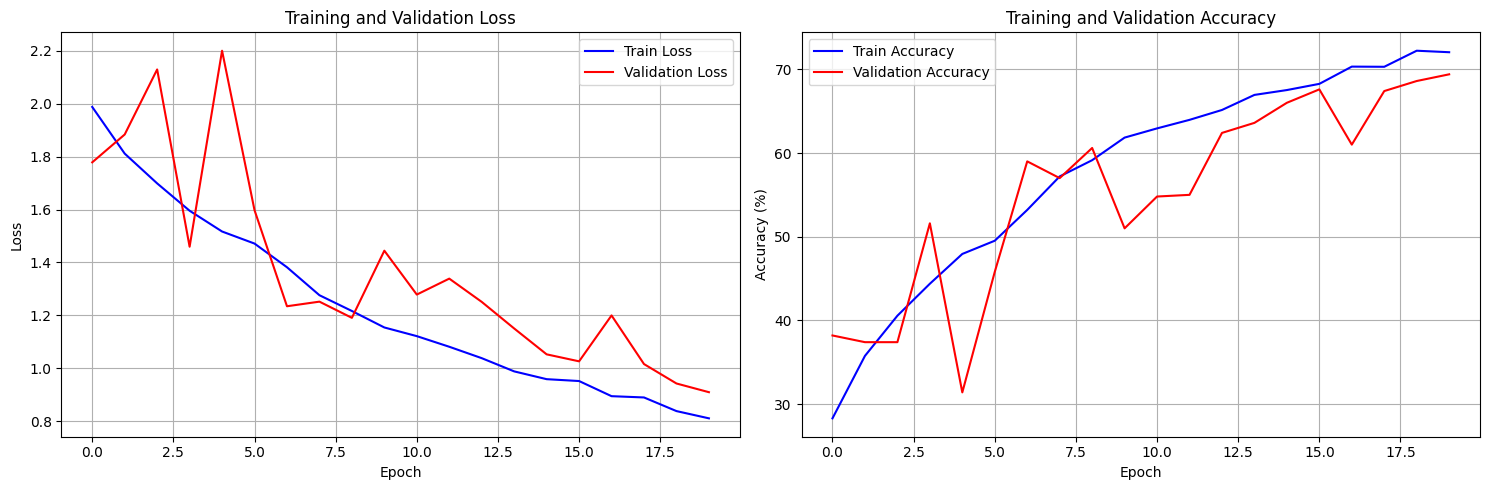

In [12]:
plot_training_history(history)

In [13]:
print(best_acc_val)

69.4


- На валидации стабильно поднимался процент 
- В целом, получилось добиться неплохой точности относительно моделей из предыдущих

In [14]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def test(model, test_loader, classes, device):
    model.to(device)
    model.eval()

    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = output.max(1)
            
            all_targets.append(target.cpu().numpy())
            all_predictions.append(predicted.cpu().numpy())

    targets = np.concatenate(all_targets)
    predictions = np.concatenate(all_predictions)

    acc = accuracy_score(targets, predictions)
    cm = confusion_matrix(targets, predictions)
    
    report_str = classification_report(
        targets, predictions,
        target_names=classes,
        digits=4,
        zero_division=0
    )

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=classes,
        yticklabels=classes,
        cbar_kws={'shrink': 0.8}
    )
    plt.title(f'Confusion Matrix (Accuracy: {acc:.4f})')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    print(f"\n✅ Test Accuracy: {100 * acc:.2f}%\n")
    print("📊 Classification Report:")
    print(report_str)

    return {
        'accuracy': acc,
        'report': report_str,
        'confusion_matrix': cm,
        'predictions': predictions,
        'targets': targets
    }

def load_tiny_imagenet_labels(words_path="data/tiny-imagenet-200/words.txt"):
    labels = {}
    with open(words_path, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) >= 2:
                wnid = parts[0]
                desc = parts[1]
                labels[wnid] = desc
    return labels

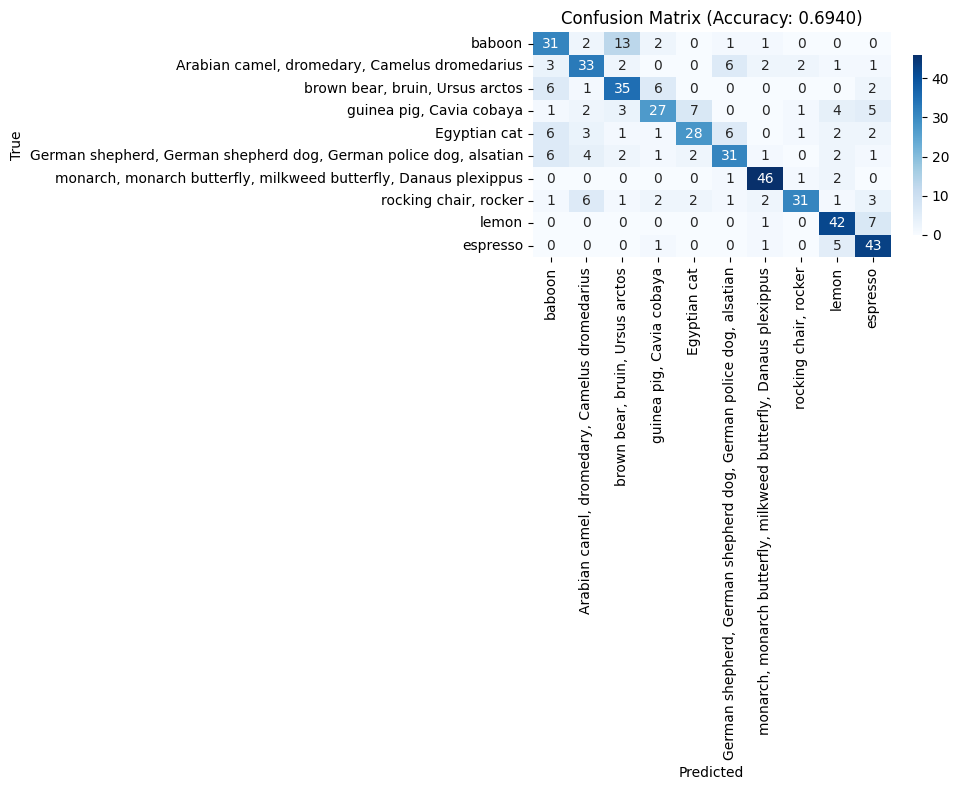


✅ Test Accuracy: 69.40%

📊 Classification Report:
                                                                   precision    recall  f1-score   support

                                                           baboon     0.5741    0.6200    0.5962        50
                    Arabian camel, dromedary, Camelus dromedarius     0.6471    0.6600    0.6535        50
                                  brown bear, bruin, Ursus arctos     0.6140    0.7000    0.6542        50
                                         guinea pig, Cavia cobaya     0.6750    0.5400    0.6000        50
                                                     Egyptian cat     0.7179    0.5600    0.6292        50
German shepherd, German shepherd dog, German police dog, alsatian     0.6739    0.6200    0.6458        50
 monarch, monarch butterfly, milkweed butterfly, Danaus plexippus     0.8519    0.9200    0.8846        50
                                            rocking chair, rocker     0.8611    0.6200    0.

In [17]:
model_final_test = SimpleResNet_32B(10)

checkpoint = torch.load('best_model.pth', map_location=device)
model_final_test.load_state_dict(checkpoint)

calsses_names = load_tiny_imagenet_labels()
calsses = [calsses_names[val_dataset.class_names[i]] for i in selected_classes] 

results = test(model_final_test, val_loader, calsses, device)

## Семинар 3: Бинарная сегментация для Луны

В этом семинаре мы будем решать задачу **бинарной сегментации** - определять где на лунной поверхности находятся камни.


## Создание кастомного Dataset для Moon Segmentation

### Структура данных:
- **render/** - исходные изображения лунной поверхности (1000 изображений)
- **ground/** - бинарные маски сегментации (0 = фон, 255 = камни)



In [18]:
class MoonSegmentationDataset(Dataset):

    def __init__(self, root_dir, image_folder='render', mask_folder='ground', 
                 image_ids=None, augmentation=None, preprocessing=None):
        self.root_dir = root_dir
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        
        images_dir = os.path.join(root_dir, 'images', image_folder)
        masks_dir = os.path.join(root_dir, 'images', mask_folder)
        
        if image_ids is None:
            all_images = os.listdir(images_dir)
            self.image_ids = [img.replace('.png', '') for img in all_images if img.endswith('.png')]
        else:
            self.image_ids = image_ids
        
    
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        
        image_path = os.path.join(self.root_dir, 'images', self.image_folder, f"{image_id}.png")
        
        # Для масок убираем префикс "render" если он есть
        # Например: render0001 - 0001
        mask_id = image_id.replace('render', '') if 'render' in image_id else image_id
        mask_path = os.path.join(self.root_dir, 'images', self.mask_folder, f"ground{mask_id}.png")
        
        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        # Так как используем opencv, то не забываем преводить из BGR в RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Нормализуем бинарную маску к [0, 1]
        # 0 = фон, 1 = камни
        mask = (mask > 0).astype(np.float32)
        
        # Применяем аугментации
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # Применяем предобработку
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        return image, mask


### Создание аугментаций с Albumentations

Для задачи сегментации важно применять одинаковые трансформации к изображению и маске!


In [21]:
# Аугментации для обучения
train_augmentation = A.Compose([
    A.Resize(128, 128),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=45, p=0.5),
    A.OneOf([
        A.GaussNoise(var_limit=(10.0, 50.0)),
        A.GaussianBlur(blur_limit=(3, 7)),
        A.MedianBlur(blur_limit=5),
    ], p=0.3),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
])

preprocessing = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_augmentation = A.Compose([
    A.Resize(128, 128),
])



/var/folders/zg/r5zs8ls50fl4d6mflwmp5zy00000gn/T/ipykernel_59121/4057520275.py:9: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0)),


### Разделение данных на train/val


In [22]:
# Путь к данным
DATA_ROOT = "data/MOON_SEGMENTATION_BINARY/"

images_dir = os.path.join(DATA_ROOT, 'images', 'render')
all_images = [img.replace('.png', '') for img in os.listdir(images_dir) if img.endswith('.png')][:100]

print(f"Всего изображений: {len(all_images)}")

train_ids, val_ids = train_test_split(all_images, test_size=0.2, random_state=42)

print(f"Train: {len(train_ids)} изображений")
print(f"Val: {len(val_ids)} изображений")

train_dataset = MoonSegmentationDataset(
    root_dir=DATA_ROOT,
    image_folder='render',
    mask_folder='ground',
    image_ids=train_ids,
    augmentation=train_augmentation,
    preprocessing=preprocessing
)

val_dataset = MoonSegmentationDataset(
    root_dir=DATA_ROOT,
    image_folder='render',
    mask_folder='ground',
    image_ids=val_ids,
    augmentation=val_augmentation,
    preprocessing=preprocessing
)

BATCH_SIZE = 4
NUM_WORKERS = 0

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=NUM_WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"Батчей в train: {len(train_loader)}")
print(f"Батчей в val: {len(val_loader)}")


Всего изображений: 100
Train: 80 изображений
Val: 20 изображений
Батчей в train: 20
Батчей в val: 5


## Визуализация данных

Посмотрим на примеры изображений и их маски сегментации


Размер батча изображений: torch.Size([4, 3, 128, 128])
Размер батча масок: torch.Size([4, 128, 128])


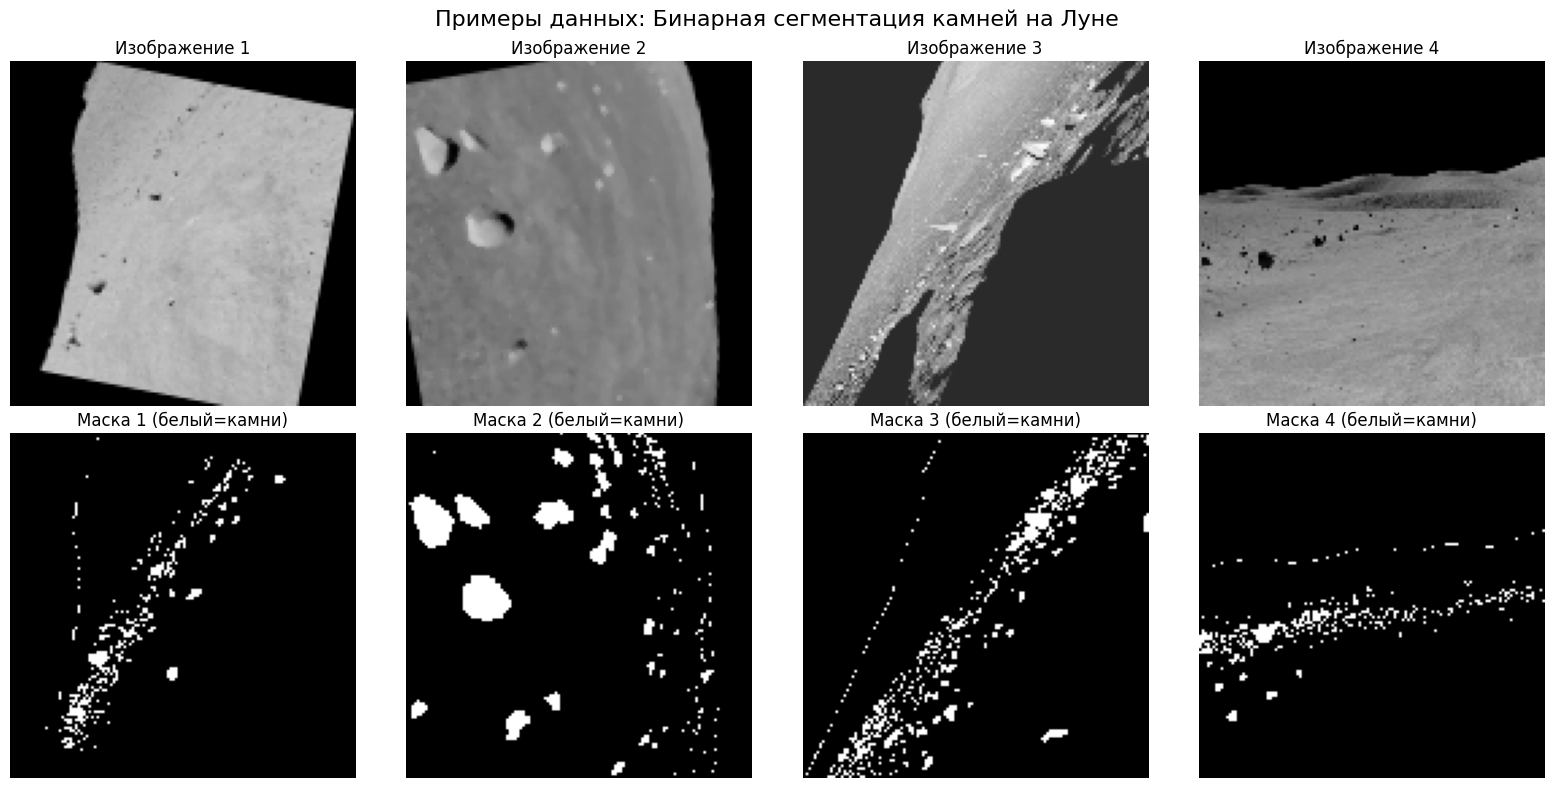

In [24]:
def denormalize(img_tensor):
    """Денормализация изображения для визуализации"""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img_tensor * std + mean
    return img.clamp(0, 1)

images, masks = next(iter(train_loader))

print(f"Размер батча изображений: {images.shape}")
print(f"Размер батча масок: {masks.shape}")

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i in range(min(4, len(images))):
    img = denormalize(images[i]).permute(1, 2, 0).numpy()
    mask = masks[i].numpy()
    
    axes[0, i].imshow(img)
    axes[0, i].set_title(f"Изображение {i+1}")
    axes[0, i].axis('off')
    
    axes[1, i].imshow(mask, cmap='gray')
    axes[1, i].set_title(f"Маска {i+1} (белый=камни)")
    axes[1, i].axis('off')

plt.suptitle("Примеры данных: Бинарная сегментация камней на Луне", fontsize=16)
plt.tight_layout()
plt.show()


---

## Кастомная U-Net архитектура

### Что такое U-Net?
**U-Net** - это архитектура для семантической сегментации, предложенная в 2015 году.

### Основные компоненты:
1. **Encoder (Downsampling)** - сжимает изображение, извлекая признаки
2. **Bottleneck** - самый глубокий слой с максимальным количеством каналов
3. **Decoder (Upsampling)** - восстанавливает разрешение
4. **Skip Connections** - соединяют encoder и decoder для сохранения деталей



In [79]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.double_conv(x)



class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, features=[16, 32, 64, 128]):
        super(UNet, self).__init__()
        
        self.encoder_blocks = nn.ModuleList()
        self.decoder_blocks = nn.ModuleList()
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        prev_channels = in_channels
        for feature in features:
            self.encoder_blocks.append(DoubleConv(prev_channels, feature))
            prev_channels = feature

        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)

        for feature in reversed(features):
            self.decoder_blocks.append(
                nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2)
            )
            self.decoder_blocks.append(
                DoubleConv(feature * 2, feature)
            )

        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
        
        total_params = sum(p.numel() for p in self.parameters())
        print(f"Параметров: {total_params:,}")
        print(f"Уровней encoder: {len(features)}")
        print(f"Конфигурация каналов: {features}")
    
    def forward(self, x):

        skip_connections = []

        for encoder_block in self.encoder_blocks:
            x = encoder_block(x)
            skip_connections.append(x)
            x = self.pool(x)
        
        x = self.bottleneck(x)
        
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.decoder_blocks), 2):
            x = self.decoder_blocks[idx](x)
            
            skip_connection = skip_connections[idx // 2]
            
            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:], 
                                mode='bilinear', align_corners=True)
            
            x = torch.cat([skip_connection, x], dim=1)
            
            x = self.decoder_blocks[idx + 1](x)

        output = self.final_conv(x)
        
        return output



model = UNet(in_channels=3, out_channels=1, features=[16, 32, 64, 128])


test_input = torch.randn(1, 3, 128, 128)
test_output = model(test_input)

print(f"   Вход:  {test_input.shape}")
print(f"   Выход: {test_output.shape}")


Параметров: 1,944,049
Уровней encoder: 4
Конфигурация каналов: [16, 32, 64, 128]
   Вход:  torch.Size([1, 3, 128, 128])
   Выход: torch.Size([1, 1, 128, 128])


Относительно базовой модели:
- Изменена конфигурация каналов для уменьшения кол-ва параметров 

---

## Функции потерь и метрики для сегментации

### Метрики сегментации:
- **Dice Loss** - популярная функция потерь для сегментации
- **IoU (Intersection over Union)** - метрика качества сегментации
- **Pixel Accuracy** - точность предсказания пикселей


In [57]:
class DiceLoss(nn.Module):
    """
    Dice Loss для бинарной сегментации
    
    Dice = 2 * |X ∩ Y| / (|X| + |Y|)
    """
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
    
    def forward(self, predictions, targets):
        predictions = torch.sigmoid(predictions)
        
        # Flatten
        predictions = predictions.view(-1)
        targets = targets.view(-1)
        
        # Dice coefficient
        intersection = (predictions * targets).sum()
        dice = (2. * intersection + self.smooth) / (predictions.sum() + targets.sum() + self.smooth)
        
        # Dice loss
        return 1 - dice


class CombinedLoss(nn.Module):

    def __init__(self, bce_weight=0.5, dice_weight=0.5):
        super(CombinedLoss, self).__init__()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
    
    def forward(self, predictions, targets):
        bce_loss = self.bce(predictions, targets)
        dice_loss = self.dice(predictions, targets)
        
        return self.bce_weight * bce_loss + self.dice_weight * dice_loss


def dice_coefficient(predictions, targets, threshold=0.5, smooth=1e-6):

    predictions = torch.sigmoid(predictions)
    predictions = (predictions > threshold).float()
    
    predictions = predictions.view(-1)
    targets = targets.view(-1)
    
    intersection = (predictions * targets).sum()
    dice = (2. * intersection + smooth) / (predictions.sum() + targets.sum() + smooth)
    
    return dice.item()


def iou_score(predictions, targets, threshold=0.5, smooth=1e-6):

    predictions = torch.sigmoid(predictions)
    predictions = (predictions > threshold).float()
    
    predictions = predictions.view(-1)
    targets = targets.view(-1)
    
    intersection = (predictions * targets).sum()
    union = predictions.sum() + targets.sum() - intersection
    
    iou = (intersection + smooth) / (union + smooth)
    
    return iou.item()


def pixel_accuracy(predictions, targets, threshold=0.5):

    predictions = torch.sigmoid(predictions)
    predictions = (predictions > threshold).float()
    correct = (predictions == targets).float().sum()
    total = targets.numel()
    
    return (correct / total).item()



In [81]:
def train_epoch(model, train_loader, criterion, optimizer, device):

    model.train()
    
    running_loss = 0.0
    running_dice = 0.0
    running_iou = 0.0
    
    pbar = tqdm(train_loader, desc="Training")
    
    for images, masks in pbar:
        images = images.to(device)
        masks = masks.unsqueeze(1).to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, masks)
        
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            dice = dice_coefficient(outputs, masks)
            iou = iou_score(outputs, masks)
        
        running_loss += loss.item()
        running_dice += dice
        running_iou += iou
        
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'dice': f'{dice:.4f}',
            'iou': f'{iou:.4f}'
        })
    
    avg_loss = running_loss / len(train_loader)
    avg_dice = running_dice / len(train_loader)
    avg_iou = running_iou / len(train_loader)
    
    return avg_loss, avg_dice, avg_iou


def validate_epoch(model, val_loader, criterion, device):

    model.eval()
    
    running_loss = 0.0
    running_dice = 0.0
    running_iou = 0.0
    running_acc = 0.0
    
    pbar = tqdm(val_loader, desc="Validation")
    
    with torch.no_grad():
        for images, masks in pbar:
            images = images.to(device)
            masks = masks.unsqueeze(1).to(device)
            
            outputs = model(images)
            
            loss = criterion(outputs, masks)
            
            dice = dice_coefficient(outputs, masks)
            iou = iou_score(outputs, masks)
            acc = pixel_accuracy(outputs, masks)
            
            running_loss += loss.item()
            running_dice += dice
            running_iou += iou
            running_acc += acc
            
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'dice': f'{dice:.4f}',
                'iou': f'{iou:.4f}',
                'acc': f'{acc:.4f}'
            })
    
    avg_loss = running_loss / len(val_loader)
    avg_dice = running_dice / len(val_loader)
    avg_iou = running_iou / len(val_loader)
    avg_acc = running_acc / len(val_loader)
    
    return avg_loss, avg_dice, avg_iou, avg_acc



### Основной цикл обучения


In [80]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=20, save_path='best_unet.pth'):

    model = model.to(device)
    
    history = {
        'train_loss': [],
        'train_dice': [],
        'train_iou': [],
        'val_loss': [],
        'val_dice': [],
        'val_iou': [],
        'val_acc': [],
        'lr': []
    }
    
    best_val_dice = 0.0
    
    for epoch in range(num_epochs):
        print(f"Эпоха {epoch+1}/{num_epochs}")
        
        # Здесь происходит основное обучение
        train_loss, train_dice, train_iou = train_epoch(
            model, train_loader, criterion, optimizer, device
        )
        
        # Валидация 
        val_loss, val_dice, val_iou, val_acc = validate_epoch(
            model, val_loader, criterion, device
        )
        
        # Обновляем learning rate (проверяем на )
        if scheduler is not None:
            scheduler.step(val_dice)
            current_lr = optimizer.param_groups[0]['lr']
        else:
            current_lr = optimizer.param_groups[0]['lr']
        
        # Сохраняем всю нашу историю
        history['train_loss'].append(train_loss)
        history['train_dice'].append(train_dice)
        history['train_iou'].append(train_iou)
        history['val_loss'].append(val_loss)
        history['val_dice'].append(val_dice)
        history['val_iou'].append(val_iou)
        history['val_acc'].append(val_acc)
        history['lr'].append(current_lr)
        
        # Выводим результаты
        print(f"\n Результаты эпохи {epoch+1}:")
        print(f"  Train - Loss: {train_loss:.4f}, Dice: {train_dice:.4f}, IoU: {train_iou:.4f}")
        print(f"  Val   - Loss: {val_loss:.4f}, Dice: {val_dice:.4f}, IoU: {val_iou:.4f}, Acc: {val_acc:.4f}")
        print(f"  LR: {current_lr:.6f}")
        
        # Сохраняем лучшую модел, можно сохранять по метрике или loss
        if val_dice > best_val_dice:
            best_val_dice = val_dice
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_dice': val_dice,
                'val_iou': val_iou,
            }, save_path)
            print(f"  Сохранена лучшая модель! Dice: {val_dice:.4f}")
    
    print(f"Лучший Val Dice: {best_val_dice:.4f}") 
    
    return history



### Запуск обучения


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"  Используем устройство: {device}")

model = UNet(in_channels=3, out_channels=1, features=[16, 32, 64, 128])

criterion = CombinedLoss(bce_weight=0.5, dice_weight=0.5)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='max',
    factor=0.5, 
    patience=3, 
)

NUM_EPOCHS = 100

history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=NUM_EPOCHS,
    save_path='best_moon_unet.pth'
)


  Используем устройство: cpu
Параметров: 1,944,049
Уровней encoder: 4
Конфигурация каналов: [16, 32, 64, 128]
Эпоха 1/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.12it/s, loss=0.7735, dice=0.1842, iou=0.1014, acc=0.3257]



 Результаты эпохи 1:
  Train - Loss: 0.7563, Dice: 0.1812, IoU: 0.1008
  Val   - Loss: 0.7681, Dice: 0.1925, IoU: 0.1079, Acc: 0.3463
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.1925
Эпоха 2/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.41it/s, loss=0.7311, dice=0.2680, iou=0.1547, acc=0.7530]



 Результаты эпохи 2:
  Train - Loss: 0.7366, Dice: 0.2230, IoU: 0.1267
  Val   - Loss: 0.7275, Dice: 0.2768, IoU: 0.1618, Acc: 0.7493
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.2768
Эпоха 3/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.08it/s, loss=0.7127, dice=0.3182, iou=0.1892, acc=0.8533]



 Результаты эпохи 3:
  Train - Loss: 0.7276, Dice: 0.2354, IoU: 0.1365
  Val   - Loss: 0.7091, Dice: 0.3308, IoU: 0.1988, Acc: 0.8380
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.3308
Эпоха 4/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.03it/s, loss=0.7025, dice=0.2943, iou=0.1725, acc=0.8990]



 Результаты эпохи 4:
  Train - Loss: 0.7141, Dice: 0.2819, IoU: 0.1701
  Val   - Loss: 0.6983, Dice: 0.3200, IoU: 0.1909, Acc: 0.8896
  LR: 0.000100
Эпоха 5/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.95it/s, loss=0.7010, dice=0.2533, iou=0.1450, acc=0.9037]



 Результаты эпохи 5:
  Train - Loss: 0.7080, Dice: 0.2751, IoU: 0.1631
  Val   - Loss: 0.6957, Dice: 0.3169, IoU: 0.1901, Acc: 0.8939
  LR: 0.000100
Эпоха 6/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.55it/s, loss=0.7391, dice=0.2815, iou=0.1638, acc=0.7464]



 Результаты эпохи 6:
  Train - Loss: 0.6975, Dice: 0.2946, IoU: 0.1761
  Val   - Loss: 0.7361, Dice: 0.3005, IoU: 0.1790, Acc: 0.7243
  LR: 0.000100
Эпоха 7/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.14it/s, loss=0.6857, dice=0.2288, iou=0.1292, acc=0.9087]



 Результаты эпохи 7:
  Train - Loss: 0.6868, Dice: 0.3107, IoU: 0.1889
  Val   - Loss: 0.6777, Dice: 0.3355, IoU: 0.2050, Acc: 0.8983
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.3355
Эпоха 8/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.18it/s, loss=0.6735, dice=0.2946, iou=0.1727, acc=0.9034]



 Результаты эпохи 8:
  Train - Loss: 0.6807, Dice: 0.2978, IoU: 0.1777
  Val   - Loss: 0.6637, Dice: 0.3884, IoU: 0.2437, Acc: 0.8985
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.3884
Эпоха 9/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.39it/s, loss=0.6710, dice=0.1020, iou=0.0537, acc=0.9043]



 Результаты эпохи 9:
  Train - Loss: 0.6788, Dice: 0.2735, IoU: 0.1621
  Val   - Loss: 0.6647, Dice: 0.2651, IoU: 0.1592, Acc: 0.8902
  LR: 0.000100
Эпоха 10/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.28it/s, loss=0.6701, dice=0.1745, iou=0.0956, acc=0.9079]



 Результаты эпохи 10:
  Train - Loss: 0.6669, Dice: 0.3437, IoU: 0.2114
  Val   - Loss: 0.6590, Dice: 0.3210, IoU: 0.1975, Acc: 0.9046
  LR: 0.000100
Эпоха 11/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.37it/s, loss=0.6607, dice=0.2210, iou=0.1242, acc=0.9086]



 Результаты эпохи 11:
  Train - Loss: 0.6685, Dice: 0.3206, IoU: 0.1956
  Val   - Loss: 0.6504, Dice: 0.3401, IoU: 0.2094, Acc: 0.9036
  LR: 0.000100
Эпоха 12/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.01it/s, loss=0.6594, dice=0.2927, iou=0.1714, acc=0.9113]



 Результаты эпохи 12:
  Train - Loss: 0.6572, Dice: 0.3590, IoU: 0.2216
  Val   - Loss: 0.6470, Dice: 0.4069, IoU: 0.2591, Acc: 0.9071
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.4069
Эпоха 13/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.51it/s, loss=0.6545, dice=0.2427, iou=0.1381, acc=0.9079]



 Результаты эпохи 13:
  Train - Loss: 0.6538, Dice: 0.3634, IoU: 0.2289
  Val   - Loss: 0.6407, Dice: 0.3854, IoU: 0.2435, Acc: 0.9049
  LR: 0.000100
Эпоха 14/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.64it/s, loss=0.6552, dice=0.1614, iou=0.0878, acc=0.9020]



 Результаты эпохи 14:
  Train - Loss: 0.6575, Dice: 0.3361, IoU: 0.2060
  Val   - Loss: 0.6448, Dice: 0.3326, IoU: 0.2054, Acc: 0.8908
  LR: 0.000100
Эпоха 15/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 12.35it/s, loss=0.6651, dice=0.3279, iou=0.1961, acc=0.8560]



 Результаты эпохи 15:
  Train - Loss: 0.6507, Dice: 0.3539, IoU: 0.2205
  Val   - Loss: 0.6473, Dice: 0.4076, IoU: 0.2593, Acc: 0.8649
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.4076
Эпоха 16/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 12.74it/s, loss=0.6515, dice=0.1249, iou=0.0666, acc=0.9036]



 Результаты эпохи 16:
  Train - Loss: 0.6513, Dice: 0.3321, IoU: 0.2040
  Val   - Loss: 0.6378, Dice: 0.3092, IoU: 0.1908, Acc: 0.8993
  LR: 0.000100
Эпоха 17/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.42it/s, loss=0.6349, dice=0.2933, iou=0.1719, acc=0.9115]



 Результаты эпохи 17:
  Train - Loss: 0.6440, Dice: 0.3687, IoU: 0.2320
  Val   - Loss: 0.6265, Dice: 0.4030, IoU: 0.2550, Acc: 0.8976
  LR: 0.000100
Эпоха 18/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.68it/s, loss=0.6417, dice=0.3412, iou=0.2057, acc=0.9049]



 Результаты эпохи 18:
  Train - Loss: 0.6345, Dice: 0.4048, IoU: 0.2586
  Val   - Loss: 0.6290, Dice: 0.4303, IoU: 0.2769, Acc: 0.9008
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.4303
Эпоха 19/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.01it/s, loss=0.6298, dice=0.2807, iou=0.1632, acc=0.9108]



 Результаты эпохи 19:
  Train - Loss: 0.6332, Dice: 0.3903, IoU: 0.2486
  Val   - Loss: 0.6203, Dice: 0.4104, IoU: 0.2624, Acc: 0.9027
  LR: 0.000100
Эпоха 20/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.81it/s, loss=0.6384, dice=0.3556, iou=0.2163, acc=0.9011]



 Результаты эпохи 20:
  Train - Loss: 0.6358, Dice: 0.3733, IoU: 0.2334
  Val   - Loss: 0.6248, Dice: 0.4308, IoU: 0.2770, Acc: 0.8968
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.4308
Эпоха 21/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 12.95it/s, loss=0.6345, dice=0.3639, iou=0.2224, acc=0.8898]



 Результаты эпохи 21:
  Train - Loss: 0.6356, Dice: 0.3532, IoU: 0.2179
  Val   - Loss: 0.6261, Dice: 0.4140, IoU: 0.2631, Acc: 0.8776
  LR: 0.000100
Эпоха 22/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.49it/s, loss=0.6491, dice=0.3532, iou=0.2145, acc=0.8342]



 Результаты эпохи 22:
  Train - Loss: 0.6238, Dice: 0.4039, IoU: 0.2567
  Val   - Loss: 0.6361, Dice: 0.4151, IoU: 0.2662, Acc: 0.8455
  LR: 0.000100
Эпоха 23/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.55it/s, loss=0.6264, dice=0.3876, iou=0.2404, acc=0.9003]



 Результаты эпохи 23:
  Train - Loss: 0.6261, Dice: 0.3804, IoU: 0.2402
  Val   - Loss: 0.6170, Dice: 0.4449, IoU: 0.2888, Acc: 0.8909
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.4449
Эпоха 24/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.36it/s, loss=0.6123, dice=0.4173, iou=0.2636, acc=0.9033]



 Результаты эпохи 24:
  Train - Loss: 0.6202, Dice: 0.3945, IoU: 0.2513
  Val   - Loss: 0.6065, Dice: 0.4568, IoU: 0.2982, Acc: 0.8927
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.4568
Эпоха 25/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.70it/s, loss=0.6154, dice=0.3588, iou=0.2186, acc=0.9072]



 Результаты эпохи 25:
  Train - Loss: 0.6216, Dice: 0.3801, IoU: 0.2388
  Val   - Loss: 0.6081, Dice: 0.4317, IoU: 0.2779, Acc: 0.8919
  LR: 0.000100
Эпоха 26/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.15it/s, loss=0.6098, dice=0.3538, iou=0.2149, acc=0.9097]



 Результаты эпохи 26:
  Train - Loss: 0.6127, Dice: 0.4075, IoU: 0.2617
  Val   - Loss: 0.6057, Dice: 0.4276, IoU: 0.2756, Acc: 0.8927
  LR: 0.000100
Эпоха 27/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 12.28it/s, loss=0.5951, dice=0.3595, iou=0.2191, acc=0.9114]



 Результаты эпохи 27:
  Train - Loss: 0.6187, Dice: 0.3743, IoU: 0.2346
  Val   - Loss: 0.5917, Dice: 0.4276, IoU: 0.2740, Acc: 0.8971
  LR: 0.000100
Эпоха 28/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.58it/s, loss=0.6026, dice=0.3327, iou=0.1996, acc=0.9081]



 Результаты эпохи 28:
  Train - Loss: 0.6051, Dice: 0.4251, IoU: 0.2731
  Val   - Loss: 0.5976, Dice: 0.4176, IoU: 0.2675, Acc: 0.8871
  LR: 0.000050
Эпоха 29/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 12.84it/s, loss=0.5980, dice=0.3745, iou=0.2304, acc=0.9140]



 Результаты эпохи 29:
  Train - Loss: 0.6067, Dice: 0.4029, IoU: 0.2583
  Val   - Loss: 0.5887, Dice: 0.4481, IoU: 0.2920, Acc: 0.9076
  LR: 0.000050
Эпоха 30/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.59it/s, loss=0.5991, dice=0.3377, iou=0.2031, acc=0.9078]



 Результаты эпохи 30:
  Train - Loss: 0.6126, Dice: 0.3837, IoU: 0.2411
  Val   - Loss: 0.5900, Dice: 0.4304, IoU: 0.2785, Acc: 0.9015
  LR: 0.000050
Эпоха 31/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 12.79it/s, loss=0.5852, dice=0.4331, iou=0.2764, acc=0.9144]



 Результаты эпохи 31:
  Train - Loss: 0.6071, Dice: 0.3944, IoU: 0.2500
  Val   - Loss: 0.5814, Dice: 0.4607, IoU: 0.3027, Acc: 0.9036
  LR: 0.000050
  Сохранена лучшая модель! Dice: 0.4607
Эпоха 32/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.09it/s, loss=0.5746, dice=0.4531, iou=0.2929, acc=0.9123]



 Результаты эпохи 32:
  Train - Loss: 0.6038, Dice: 0.4002, IoU: 0.2569
  Val   - Loss: 0.5783, Dice: 0.4624, IoU: 0.3040, Acc: 0.8913
  LR: 0.000050
  Сохранена лучшая модель! Dice: 0.4624
Эпоха 33/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.22it/s, loss=0.5859, dice=0.4270, iou=0.2715, acc=0.9095]



 Результаты эпохи 33:
  Train - Loss: 0.6002, Dice: 0.4232, IoU: 0.2711
  Val   - Loss: 0.5862, Dice: 0.4578, IoU: 0.3004, Acc: 0.8965
  LR: 0.000050
Эпоха 34/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 12.99it/s, loss=0.5842, dice=0.4468, iou=0.2877, acc=0.9040]



 Результаты эпохи 34:
  Train - Loss: 0.6019, Dice: 0.4024, IoU: 0.2557
  Val   - Loss: 0.5841, Dice: 0.4624, IoU: 0.3034, Acc: 0.8916
  LR: 0.000050
Эпоха 35/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.53it/s, loss=0.5778, dice=0.4364, iou=0.2791, acc=0.9109]



 Результаты эпохи 35:
  Train - Loss: 0.6062, Dice: 0.3792, IoU: 0.2403
  Val   - Loss: 0.5741, Dice: 0.4614, IoU: 0.3031, Acc: 0.8984
  LR: 0.000050
Эпоха 36/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.24it/s, loss=0.5725, dice=0.4411, iou=0.2830, acc=0.9089]



 Результаты эпохи 36:
  Train - Loss: 0.5996, Dice: 0.4061, IoU: 0.2606
  Val   - Loss: 0.5720, Dice: 0.4616, IoU: 0.3042, Acc: 0.8933
  LR: 0.000025
Эпоха 37/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.04it/s, loss=0.5739, dice=0.4603, iou=0.2990, acc=0.9175]



 Результаты эпохи 37:
  Train - Loss: 0.5943, Dice: 0.4206, IoU: 0.2739
  Val   - Loss: 0.5744, Dice: 0.4708, IoU: 0.3126, Acc: 0.9003
  LR: 0.000025
  Сохранена лучшая модель! Dice: 0.4708
Эпоха 38/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 12.65it/s, loss=0.5743, dice=0.4499, iou=0.2902, acc=0.9157]



 Результаты эпохи 38:
  Train - Loss: 0.5937, Dice: 0.4217, IoU: 0.2710
  Val   - Loss: 0.5729, Dice: 0.4711, IoU: 0.3129, Acc: 0.9007
  LR: 0.000025
  Сохранена лучшая модель! Dice: 0.4711
Эпоха 39/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.94it/s, loss=0.5767, dice=0.4590, iou=0.2979, acc=0.9170]



 Результаты эпохи 39:
  Train - Loss: 0.5907, Dice: 0.4406, IoU: 0.2870
  Val   - Loss: 0.5758, Dice: 0.4668, IoU: 0.3089, Acc: 0.9009
  LR: 0.000025
Эпоха 40/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.27it/s, loss=0.5761, dice=0.4506, iou=0.2908, acc=0.9148]



 Результаты эпохи 40:
  Train - Loss: 0.5976, Dice: 0.3986, IoU: 0.2548
  Val   - Loss: 0.5740, Dice: 0.4688, IoU: 0.3107, Acc: 0.8995
  LR: 0.000025
Эпоха 41/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.93it/s, loss=0.5643, dice=0.4780, iou=0.3140, acc=0.9175]



 Результаты эпохи 41:
  Train - Loss: 0.6006, Dice: 0.3807, IoU: 0.2399
  Val   - Loss: 0.5679, Dice: 0.4712, IoU: 0.3113, Acc: 0.8995
  LR: 0.000025
  Сохранена лучшая модель! Dice: 0.4712
Эпоха 42/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.54it/s, loss=0.5701, dice=0.4672, iou=0.3048, acc=0.9198]



 Результаты эпохи 42:
  Train - Loss: 0.5901, Dice: 0.4337, IoU: 0.2829
  Val   - Loss: 0.5690, Dice: 0.4719, IoU: 0.3124, Acc: 0.9067
  LR: 0.000025
  Сохранена лучшая модель! Dice: 0.4719
Эпоха 43/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.47it/s, loss=0.5690, dice=0.4745, iou=0.3111, acc=0.9184]



 Результаты эпохи 43:
  Train - Loss: 0.5936, Dice: 0.4240, IoU: 0.2720
  Val   - Loss: 0.5696, Dice: 0.4744, IoU: 0.3153, Acc: 0.9027
  LR: 0.000025
  Сохранена лучшая модель! Dice: 0.4744
Эпоха 44/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.54it/s, loss=0.5698, dice=0.4938, iou=0.3278, acc=0.9160]



 Результаты эпохи 44:
  Train - Loss: 0.5853, Dice: 0.4462, IoU: 0.2948
  Val   - Loss: 0.5708, Dice: 0.4827, IoU: 0.3223, Acc: 0.8999
  LR: 0.000025
  Сохранена лучшая модель! Dice: 0.4827
Эпоха 45/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.61it/s, loss=0.5686, dice=0.4873, iou=0.3222, acc=0.9218]



 Результаты эпохи 45:
  Train - Loss: 0.5870, Dice: 0.4345, IoU: 0.2838
  Val   - Loss: 0.5684, Dice: 0.4795, IoU: 0.3201, Acc: 0.9035
  LR: 0.000025
Эпоха 46/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.50it/s, loss=0.5675, dice=0.4868, iou=0.3217, acc=0.9198]



 Результаты эпохи 46:
  Train - Loss: 0.5889, Dice: 0.4216, IoU: 0.2734
  Val   - Loss: 0.5685, Dice: 0.4736, IoU: 0.3146, Acc: 0.9029
  LR: 0.000025
Эпоха 47/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.44it/s, loss=0.5679, dice=0.4824, iou=0.3179, acc=0.9110]



 Результаты эпохи 47:
  Train - Loss: 0.5890, Dice: 0.4267, IoU: 0.2784
  Val   - Loss: 0.5718, Dice: 0.4703, IoU: 0.3115, Acc: 0.8892
  LR: 0.000025
Эпоха 48/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.64it/s, loss=0.5771, dice=0.3344, iou=0.2008, acc=0.9085]



 Результаты эпохи 48:
  Train - Loss: 0.5901, Dice: 0.4168, IoU: 0.2714
  Val   - Loss: 0.5729, Dice: 0.4183, IoU: 0.2707, Acc: 0.8936
  LR: 0.000013
Эпоха 49/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.77it/s, loss=0.5684, dice=0.4668, iou=0.3044, acc=0.9148]



 Результаты эпохи 49:
  Train - Loss: 0.5835, Dice: 0.4377, IoU: 0.2858
  Val   - Loss: 0.5684, Dice: 0.4700, IoU: 0.3118, Acc: 0.8995
  LR: 0.000013
Эпоха 50/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.02it/s, loss=0.5632, dice=0.5080, iou=0.3405, acc=0.9108]



 Результаты эпохи 50:
  Train - Loss: 0.5849, Dice: 0.4406, IoU: 0.2890
  Val   - Loss: 0.5713, Dice: 0.4827, IoU: 0.3224, Acc: 0.8900
  LR: 0.000013
  Сохранена лучшая модель! Dice: 0.4827
Эпоха 51/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.87it/s, loss=0.5679, dice=0.4761, iou=0.3124, acc=0.9129]



 Результаты эпохи 51:
  Train - Loss: 0.5840, Dice: 0.4318, IoU: 0.2818
  Val   - Loss: 0.5694, Dice: 0.4726, IoU: 0.3142, Acc: 0.8954
  LR: 0.000013
Эпоха 52/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.77it/s, loss=0.5661, dice=0.4633, iou=0.3015, acc=0.9148]



 Результаты эпохи 52:
  Train - Loss: 0.5865, Dice: 0.4210, IoU: 0.2725
  Val   - Loss: 0.5681, Dice: 0.4667, IoU: 0.3093, Acc: 0.8958
  LR: 0.000006
Эпоха 53/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 11.42it/s, loss=0.5660, dice=0.4753, iou=0.3117, acc=0.9162]



 Результаты эпохи 53:
  Train - Loss: 0.5816, Dice: 0.4444, IoU: 0.2894
  Val   - Loss: 0.5666, Dice: 0.4781, IoU: 0.3190, Acc: 0.9011
  LR: 0.000006
Эпоха 54/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.00it/s, loss=0.5622, dice=0.4990, iou=0.3325, acc=0.9159]



 Результаты эпохи 54:
  Train - Loss: 0.5854, Dice: 0.4229, IoU: 0.2777
  Val   - Loss: 0.5653, Dice: 0.4853, IoU: 0.3244, Acc: 0.8987
  LR: 0.000006
  Сохранена лучшая модель! Dice: 0.4853
Эпоха 55/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.85it/s, loss=0.5645, dice=0.4932, iou=0.3273, acc=0.9146]



 Результаты эпохи 55:
  Train - Loss: 0.5820, Dice: 0.4508, IoU: 0.2964
  Val   - Loss: 0.5656, Dice: 0.4849, IoU: 0.3244, Acc: 0.8989
  LR: 0.000006
Эпоха 56/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.71it/s, loss=0.5594, dice=0.5069, iou=0.3395, acc=0.9160]



 Результаты эпохи 56:
  Train - Loss: 0.5908, Dice: 0.4098, IoU: 0.2626
  Val   - Loss: 0.5633, Dice: 0.4891, IoU: 0.3275, Acc: 0.8982
  LR: 0.000006
  Сохранена лучшая модель! Dice: 0.4891
Эпоха 57/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.70it/s, loss=0.5673, dice=0.4913, iou=0.3257, acc=0.9132]



 Результаты эпохи 57:
  Train - Loss: 0.5822, Dice: 0.4362, IoU: 0.2861
  Val   - Loss: 0.5685, Dice: 0.4822, IoU: 0.3224, Acc: 0.8959
  LR: 0.000006
Эпоха 58/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.47it/s, loss=0.5637, dice=0.4888, iou=0.3234, acc=0.9160]



 Результаты эпохи 58:
  Train - Loss: 0.5846, Dice: 0.4301, IoU: 0.2808
  Val   - Loss: 0.5645, Dice: 0.4846, IoU: 0.3243, Acc: 0.8997
  LR: 0.000006
Эпоха 59/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 12.38it/s, loss=0.5629, dice=0.4809, iou=0.3165, acc=0.9164]



 Результаты эпохи 59:
  Train - Loss: 0.5843, Dice: 0.4411, IoU: 0.2898
  Val   - Loss: 0.5647, Dice: 0.4802, IoU: 0.3208, Acc: 0.9000
  LR: 0.000006
Эпоха 60/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 12.31it/s, loss=0.5636, dice=0.4834, iou=0.3188, acc=0.9146]



 Результаты эпохи 60:
  Train - Loss: 0.5859, Dice: 0.4221, IoU: 0.2735
  Val   - Loss: 0.5658, Dice: 0.4799, IoU: 0.3202, Acc: 0.8987
  LR: 0.000003
Эпоха 61/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.50it/s, loss=0.5612, dice=0.4802, iou=0.3160, acc=0.9198]



 Результаты эпохи 61:
  Train - Loss: 0.5812, Dice: 0.4420, IoU: 0.2891
  Val   - Loss: 0.5615, Dice: 0.4816, IoU: 0.3216, Acc: 0.9062
  LR: 0.000003
Эпоха 62/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.41it/s, loss=0.5596, dice=0.4933, iou=0.3274, acc=0.9175]



 Результаты эпохи 62:
  Train - Loss: 0.5810, Dice: 0.4417, IoU: 0.2891
  Val   - Loss: 0.5618, Dice: 0.4862, IoU: 0.3256, Acc: 0.9021
  LR: 0.000003
Эпоха 63/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.03it/s, loss=0.5528, dice=0.5122, iou=0.3443, acc=0.9178]



 Результаты эпохи 63:
  Train - Loss: 0.5787, Dice: 0.4486, IoU: 0.2919
  Val   - Loss: 0.5584, Dice: 0.4906, IoU: 0.3294, Acc: 0.8995
  LR: 0.000003
  Сохранена лучшая модель! Dice: 0.4906
Эпоха 64/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 12.56it/s, loss=0.5520, dice=0.5054, iou=0.3381, acc=0.9206]



 Результаты эпохи 64:
  Train - Loss: 0.5819, Dice: 0.4379, IoU: 0.2854
  Val   - Loss: 0.5580, Dice: 0.4893, IoU: 0.3280, Acc: 0.9037
  LR: 0.000003
Эпоха 65/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.89it/s, loss=0.5593, dice=0.5010, iou=0.3342, acc=0.9168]



 Результаты эпохи 65:
  Train - Loss: 0.5760, Dice: 0.4567, IoU: 0.3015
  Val   - Loss: 0.5638, Dice: 0.4895, IoU: 0.3287, Acc: 0.8997
  LR: 0.000003
Эпоха 66/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.10it/s, loss=0.5580, dice=0.4957, iou=0.3295, acc=0.9180]



 Результаты эпохи 66:
  Train - Loss: 0.5794, Dice: 0.4518, IoU: 0.2980
  Val   - Loss: 0.5624, Dice: 0.4887, IoU: 0.3282, Acc: 0.9011
  LR: 0.000003
Эпоха 67/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.42it/s, loss=0.5631, dice=0.4876, iou=0.3224, acc=0.9140]



 Результаты эпохи 67:
  Train - Loss: 0.5845, Dice: 0.4200, IoU: 0.2726
  Val   - Loss: 0.5651, Dice: 0.4832, IoU: 0.3236, Acc: 0.8981
  LR: 0.000002
Эпоха 68/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.09it/s, loss=0.5596, dice=0.5026, iou=0.3356, acc=0.9122]



 Результаты эпохи 68:
  Train - Loss: 0.5826, Dice: 0.4296, IoU: 0.2812
  Val   - Loss: 0.5654, Dice: 0.4826, IoU: 0.3227, Acc: 0.8922
  LR: 0.000002
Эпоха 69/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.21it/s, loss=0.5551, dice=0.5016, iou=0.3347, acc=0.9170]



 Результаты эпохи 69:
  Train - Loss: 0.5761, Dice: 0.4604, IoU: 0.3052
  Val   - Loss: 0.5610, Dice: 0.4914, IoU: 0.3304, Acc: 0.9000
  LR: 0.000002
  Сохранена лучшая модель! Dice: 0.4914
Эпоха 70/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.63it/s, loss=0.5554, dice=0.5125, iou=0.3445, acc=0.9160]



 Результаты эпохи 70:
  Train - Loss: 0.5786, Dice: 0.4509, IoU: 0.2966
  Val   - Loss: 0.5620, Dice: 0.4941, IoU: 0.3324, Acc: 0.8990
  LR: 0.000002
  Сохранена лучшая модель! Dice: 0.4941
Эпоха 71/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.06it/s, loss=0.5640, dice=0.4928, iou=0.3270, acc=0.9135]



 Результаты эпохи 71:
  Train - Loss: 0.5819, Dice: 0.4330, IoU: 0.2826
  Val   - Loss: 0.5654, Dice: 0.4849, IoU: 0.3248, Acc: 0.8967
  LR: 0.000002
Эпоха 72/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 12.27it/s, loss=0.5595, dice=0.5016, iou=0.3347, acc=0.9136]



 Результаты эпохи 72:
  Train - Loss: 0.5791, Dice: 0.4453, IoU: 0.2929
  Val   - Loss: 0.5639, Dice: 0.4837, IoU: 0.3237, Acc: 0.8949
  LR: 0.000002
Эпоха 73/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.36it/s, loss=0.5589, dice=0.5133, iou=0.3453, acc=0.9128]



 Результаты эпохи 73:
  Train - Loss: 0.5864, Dice: 0.4144, IoU: 0.2684
  Val   - Loss: 0.5657, Dice: 0.4830, IoU: 0.3227, Acc: 0.8926
  LR: 0.000002
Эпоха 74/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.27it/s, loss=0.5612, dice=0.5021, iou=0.3352, acc=0.9139]



 Результаты эпохи 74:
  Train - Loss: 0.5858, Dice: 0.4229, IoU: 0.2724
  Val   - Loss: 0.5650, Dice: 0.4856, IoU: 0.3253, Acc: 0.8957
  LR: 0.000001
Эпоха 75/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.28it/s, loss=0.5580, dice=0.5126, iou=0.3446, acc=0.9157]



 Результаты эпохи 75:
  Train - Loss: 0.5787, Dice: 0.4515, IoU: 0.2968
  Val   - Loss: 0.5630, Dice: 0.4896, IoU: 0.3285, Acc: 0.8972
  LR: 0.000001
Эпоха 76/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.26it/s, loss=0.5558, dice=0.5031, iou=0.3361, acc=0.9163]



 Результаты эпохи 76:
  Train - Loss: 0.5753, Dice: 0.4635, IoU: 0.3066
  Val   - Loss: 0.5605, Dice: 0.4899, IoU: 0.3289, Acc: 0.8986
  LR: 0.000001
Эпоха 77/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 12.62it/s, loss=0.5547, dice=0.5176, iou=0.3491, acc=0.9179]



 Результаты эпохи 77:
  Train - Loss: 0.5756, Dice: 0.4609, IoU: 0.3019
  Val   - Loss: 0.5614, Dice: 0.4946, IoU: 0.3330, Acc: 0.9000
  LR: 0.000001
  Сохранена лучшая модель! Dice: 0.4946
Эпоха 78/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.19it/s, loss=0.5631, dice=0.4977, iou=0.3313, acc=0.9122]



 Результаты эпохи 78:
  Train - Loss: 0.5786, Dice: 0.4495, IoU: 0.2961
  Val   - Loss: 0.5659, Dice: 0.4807, IoU: 0.3213, Acc: 0.8934
  LR: 0.000001
Эпоха 79/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.35it/s, loss=0.5586, dice=0.4976, iou=0.3312, acc=0.9166]



 Результаты эпохи 79:
  Train - Loss: 0.5788, Dice: 0.4478, IoU: 0.2962
  Val   - Loss: 0.5623, Dice: 0.4855, IoU: 0.3253, Acc: 0.9002
  LR: 0.000001
Эпоха 80/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.72it/s, loss=0.5537, dice=0.5034, iou=0.3364, acc=0.9181]



 Результаты эпохи 80:
  Train - Loss: 0.5879, Dice: 0.4054, IoU: 0.2618
  Val   - Loss: 0.5592, Dice: 0.4890, IoU: 0.3282, Acc: 0.9005
  LR: 0.000001
Эпоха 81/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 12.72it/s, loss=0.5567, dice=0.5107, iou=0.3429, acc=0.9159]



 Результаты эпохи 81:
  Train - Loss: 0.5844, Dice: 0.4270, IoU: 0.2758
  Val   - Loss: 0.5627, Dice: 0.4881, IoU: 0.3276, Acc: 0.8966
  LR: 0.000000
Эпоха 82/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.08it/s, loss=0.5551, dice=0.5176, iou=0.3491, acc=0.9171]



 Результаты эпохи 82:
  Train - Loss: 0.5737, Dice: 0.4676, IoU: 0.3098
  Val   - Loss: 0.5619, Dice: 0.4956, IoU: 0.3336, Acc: 0.8990
  LR: 0.000000
  Сохранена лучшая модель! Dice: 0.4956
Эпоха 83/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.13it/s, loss=0.5535, dice=0.5020, iou=0.3352, acc=0.9183]



 Результаты эпохи 83:
  Train - Loss: 0.5787, Dice: 0.4527, IoU: 0.3005
  Val   - Loss: 0.5606, Dice: 0.4886, IoU: 0.3279, Acc: 0.9008
  LR: 0.000000
Эпоха 84/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.97it/s, loss=0.5611, dice=0.4811, iou=0.3167, acc=0.9160]



 Результаты эпохи 84:
  Train - Loss: 0.5827, Dice: 0.4357, IoU: 0.2842
  Val   - Loss: 0.5631, Dice: 0.4780, IoU: 0.3190, Acc: 0.8996
  LR: 0.000000
Эпоха 85/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 12.37it/s, loss=0.5581, dice=0.4915, iou=0.3258, acc=0.9165]



 Результаты эпохи 85:
  Train - Loss: 0.5841, Dice: 0.4284, IoU: 0.2800
  Val   - Loss: 0.5609, Dice: 0.4855, IoU: 0.3253, Acc: 0.9004
  LR: 0.000000
Эпоха 86/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.00it/s, loss=0.5543, dice=0.5071, iou=0.3397, acc=0.9167]



 Результаты эпохи 86:
  Train - Loss: 0.5781, Dice: 0.4487, IoU: 0.2946
  Val   - Loss: 0.5604, Dice: 0.4891, IoU: 0.3285, Acc: 0.8983
  LR: 0.000000
Эпоха 87/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.69it/s, loss=0.5571, dice=0.5152, iou=0.3470, acc=0.9162]



 Результаты эпохи 87:
  Train - Loss: 0.5769, Dice: 0.4495, IoU: 0.2951
  Val   - Loss: 0.5633, Dice: 0.4916, IoU: 0.3304, Acc: 0.8980
  LR: 0.000000
Эпоха 88/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.60it/s, loss=0.5608, dice=0.5099, iou=0.3422, acc=0.9139]



 Результаты эпохи 88:
  Train - Loss: 0.5772, Dice: 0.4540, IoU: 0.2988
  Val   - Loss: 0.5656, Dice: 0.4902, IoU: 0.3294, Acc: 0.8952
  LR: 0.000000
Эпоха 89/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 12.80it/s, loss=0.5570, dice=0.5148, iou=0.3466, acc=0.9161]



 Результаты эпохи 89:
  Train - Loss: 0.5825, Dice: 0.4315, IoU: 0.2808
  Val   - Loss: 0.5629, Dice: 0.4915, IoU: 0.3305, Acc: 0.8969
  LR: 0.000000
Эпоха 90/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.59it/s, loss=0.5586, dice=0.5185, iou=0.3500, acc=0.9163]



 Результаты эпохи 90:
  Train - Loss: 0.5805, Dice: 0.4382, IoU: 0.2884
  Val   - Loss: 0.5631, Dice: 0.4945, IoU: 0.3328, Acc: 0.8989
  LR: 0.000000
Эпоха 91/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.24it/s, loss=0.5527, dice=0.5135, iou=0.3454, acc=0.9190]



 Результаты эпохи 91:
  Train - Loss: 0.5782, Dice: 0.4505, IoU: 0.2954
  Val   - Loss: 0.5608, Dice: 0.4877, IoU: 0.3263, Acc: 0.9012
  LR: 0.000000
Эпоха 92/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.48it/s, loss=0.5604, dice=0.4804, iou=0.3161, acc=0.9166]



 Результаты эпохи 92:
  Train - Loss: 0.5842, Dice: 0.4205, IoU: 0.2745
  Val   - Loss: 0.5609, Dice: 0.4820, IoU: 0.3224, Acc: 0.9026
  LR: 0.000000
Эпоха 93/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.17it/s, loss=0.5606, dice=0.4899, iou=0.3244, acc=0.9151]



 Результаты эпохи 93:
  Train - Loss: 0.5816, Dice: 0.4338, IoU: 0.2838
  Val   - Loss: 0.5621, Dice: 0.4811, IoU: 0.3218, Acc: 0.8980
  LR: 0.000000
Эпоха 94/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.27it/s, loss=0.5578, dice=0.5119, iou=0.3440, acc=0.9183]



 Результаты эпохи 94:
  Train - Loss: 0.5720, Dice: 0.4728, IoU: 0.3140
  Val   - Loss: 0.5623, Dice: 0.4935, IoU: 0.3323, Acc: 0.9016
  LR: 0.000000
Эпоха 95/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.63it/s, loss=0.5598, dice=0.4965, iou=0.3302, acc=0.9166]



 Результаты эпохи 95:
  Train - Loss: 0.5845, Dice: 0.4254, IoU: 0.2774
  Val   - Loss: 0.5623, Dice: 0.4876, IoU: 0.3270, Acc: 0.9012
  LR: 0.000000
Эпоха 96/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.38it/s, loss=0.5568, dice=0.4997, iou=0.3331, acc=0.9162]



 Результаты эпохи 96:
  Train - Loss: 0.5798, Dice: 0.4416, IoU: 0.2900
  Val   - Loss: 0.5626, Dice: 0.4854, IoU: 0.3252, Acc: 0.8970
  LR: 0.000000
Эпоха 97/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.26it/s, loss=0.5643, dice=0.4933, iou=0.3274, acc=0.9113]



 Результаты эпохи 97:
  Train - Loss: 0.5828, Dice: 0.4228, IoU: 0.2753
  Val   - Loss: 0.5666, Dice: 0.4800, IoU: 0.3208, Acc: 0.8933
  LR: 0.000000
Эпоха 98/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.59it/s, loss=0.5617, dice=0.5050, iou=0.3377, acc=0.9131]



 Результаты эпохи 98:
  Train - Loss: 0.5788, Dice: 0.4369, IoU: 0.2850
  Val   - Loss: 0.5650, Dice: 0.4855, IoU: 0.3251, Acc: 0.8948
  LR: 0.000000
Эпоха 99/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.26it/s, loss=0.5571, dice=0.4999, iou=0.3332, acc=0.9169]



 Результаты эпохи 99:
  Train - Loss: 0.5774, Dice: 0.4551, IoU: 0.3007
  Val   - Loss: 0.5611, Dice: 0.4865, IoU: 0.3261, Acc: 0.8997
  LR: 0.000000
Эпоха 100/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 12.89it/s, loss=0.5552, dice=0.4991, iou=0.3325, acc=0.9191]


 Результаты эпохи 100:
  Train - Loss: 0.5790, Dice: 0.4510, IoU: 0.2977
  Val   - Loss: 0.5584, Dice: 0.4883, IoU: 0.3276, Acc: 0.9028
  LR: 0.000000
Лучший Val Dice: 0.4956


---

## Визуализация результатов обучения


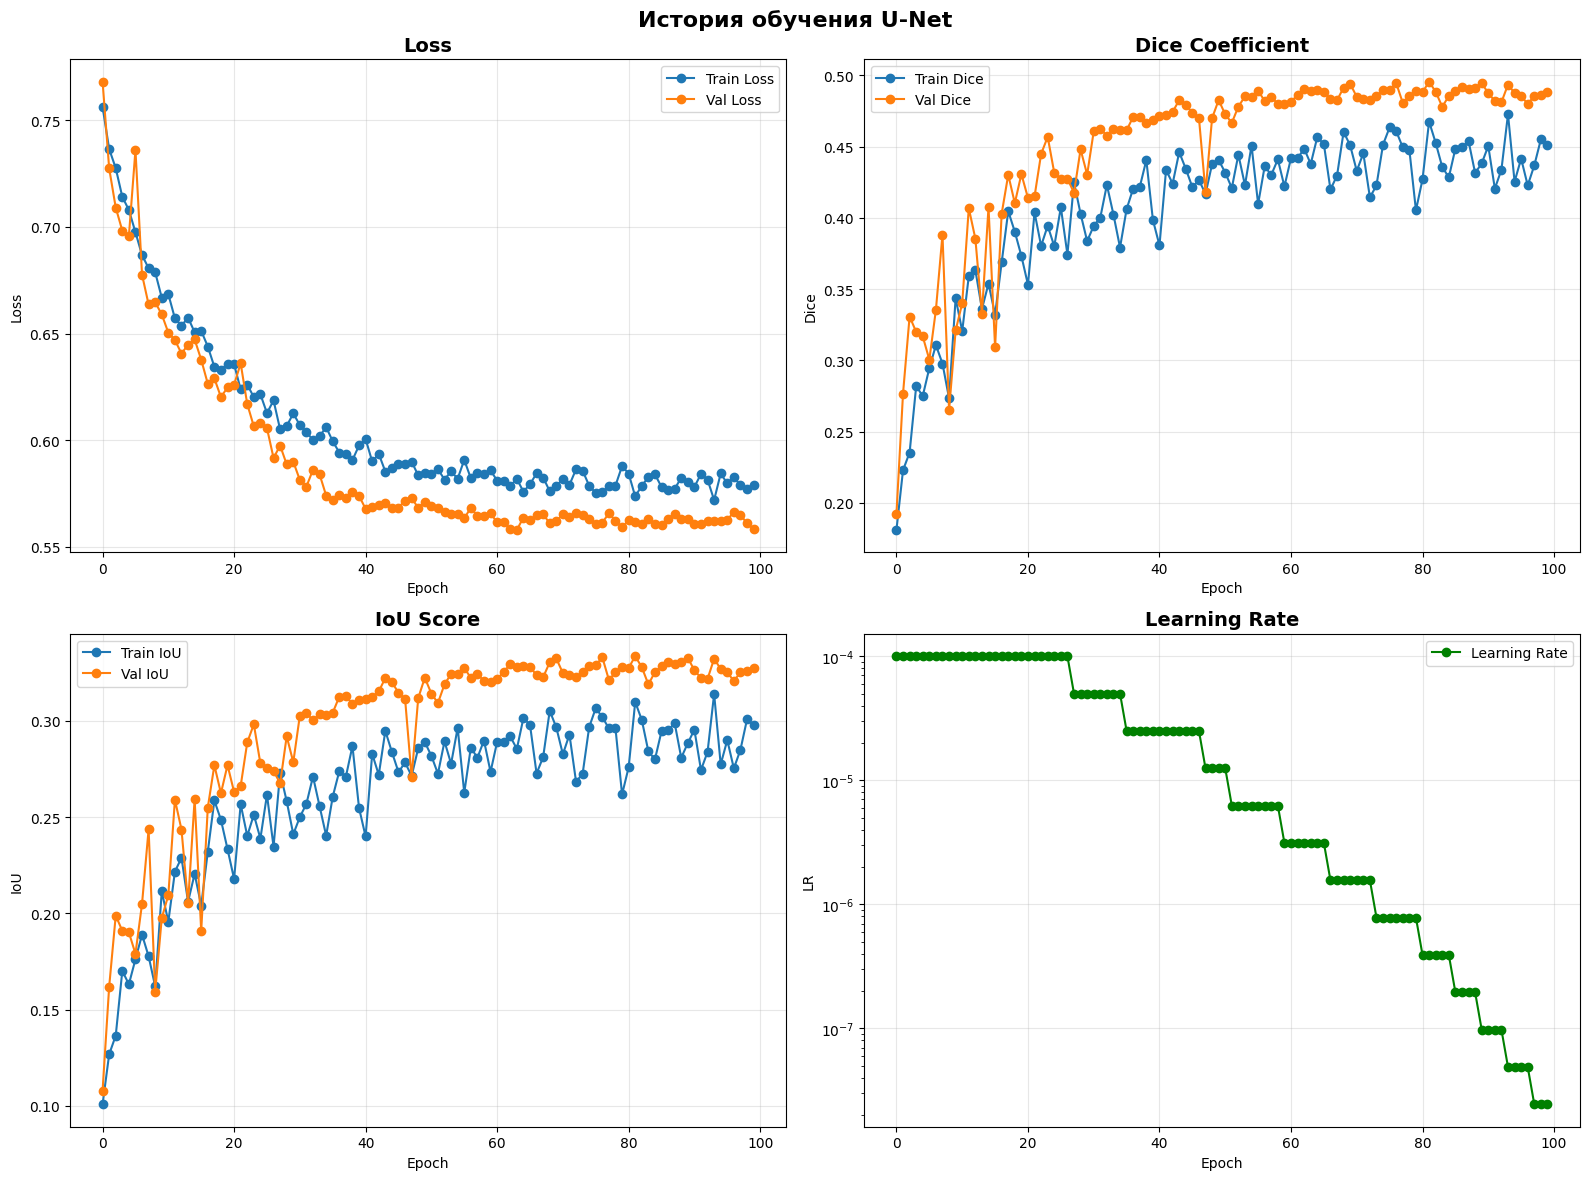

Train Loss: 0.5790
Val Loss: 0.5584
Train Dice: 0.4510
Val Dice: 0.4883
Train IoU: 0.2977
Val IoU: 0.3276
Val Accuracy: 0.9028


In [83]:
def plot_training_history(history):

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Loss
    axes[0, 0].plot(history['train_loss'], label='Train Loss', marker='o')
    axes[0, 0].plot(history['val_loss'], label='Val Loss', marker='o')
    axes[0, 0].set_title('Loss', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Dice Coefficient
    axes[0, 1].plot(history['train_dice'], label='Train Dice', marker='o')
    axes[0, 1].plot(history['val_dice'], label='Val Dice', marker='o')
    axes[0, 1].set_title('Dice Coefficient', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Dice')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # IoU Score
    axes[1, 0].plot(history['train_iou'], label='Train IoU', marker='o')
    axes[1, 0].plot(history['val_iou'], label='Val IoU', marker='o')
    axes[1, 0].set_title('IoU Score', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('IoU')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Learning Rate
    axes[1, 1].plot(history['lr'], label='Learning Rate', marker='o', color='green')
    axes[1, 1].set_title('Learning Rate', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('LR')
    axes[1, 1].set_yscale('log')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.suptitle('История обучения U-Net', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    

    print(f"Train Loss: {history['train_loss'][-1]:.4f}")
    print(f"Val Loss: {history['val_loss'][-1]:.4f}")
    print(f"Train Dice: {history['train_dice'][-1]:.4f}")
    print(f"Val Dice: {history['val_dice'][-1]:.4f}")
    print(f"Train IoU: {history['train_iou'][-1]:.4f}")
    print(f"Val IoU: {history['val_iou'][-1]:.4f}")
    print(f"Val Accuracy: {history['val_acc'][-1]:.4f}")

plot_training_history(history)


- Видно, что модель реально обучается, но после 50 эпох улучшения минимальны

## Визуализация предсказаний модели


In [84]:
def visualize_predictions(model, dataloader, device, num_samples=4):

    model.eval()
    
    images, masks = next(iter(dataloader))
    images = images.to(device)
    masks = masks.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        predictions = torch.sigmoid(outputs)
        predictions = (predictions > 0.5).float()
    
    images = images.cpu()
    masks = masks.cpu()
    predictions = predictions.cpu()
    
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4*num_samples))
    
    for i in range(min(num_samples, len(images))):
        img = denormalize(images[i]).permute(1, 2, 0).numpy()
        mask_true = masks[i, :,:].numpy()
        mask_pred = predictions[i, 0].numpy()
        
        axes[i, 0].imshow(img)
        axes[i, 0].set_title('Исходное изображение', fontsize=12)
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(mask_true, cmap='gray')
        axes[i, 1].set_title('Истинная маска', fontsize=12)
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(mask_pred, cmap='gray')
        axes[i, 2].set_title('Предсказание', fontsize=12)
        axes[i, 2].axis('off')
        
        overlay = img.copy()
        overlay[mask_pred > 0.5] = [0, 1, 0]
        
        axes[i, 3].imshow(overlay)
        axes[i, 3].set_title('Наложение', fontsize=12)
        axes[i, 3].axis('off')
        
        dice = dice_coefficient(outputs[i:i+1], masks[i:i+1])
        iou = iou_score(outputs[i:i+1], masks[i:i+1])
        
        fig.text(0.5, 1 - (i + 0.5) / num_samples, 
                f'Dice: {dice:.4f} | IoU: {iou:.4f}',
                ha='center', fontsize=10, fontweight='bold')
    
    plt.suptitle('Предсказания модели U-Net', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

visualize_predictions(model, val_loader, device, num_samples=4)


## Загрузка и тестирование лучшей модели


Параметров: 1,944,049
Уровней encoder: 4
Конфигурация каналов: [16, 32, 64, 128]
Эпоха: 82
Val Dice: 0.4956
Val IoU: 0.3336


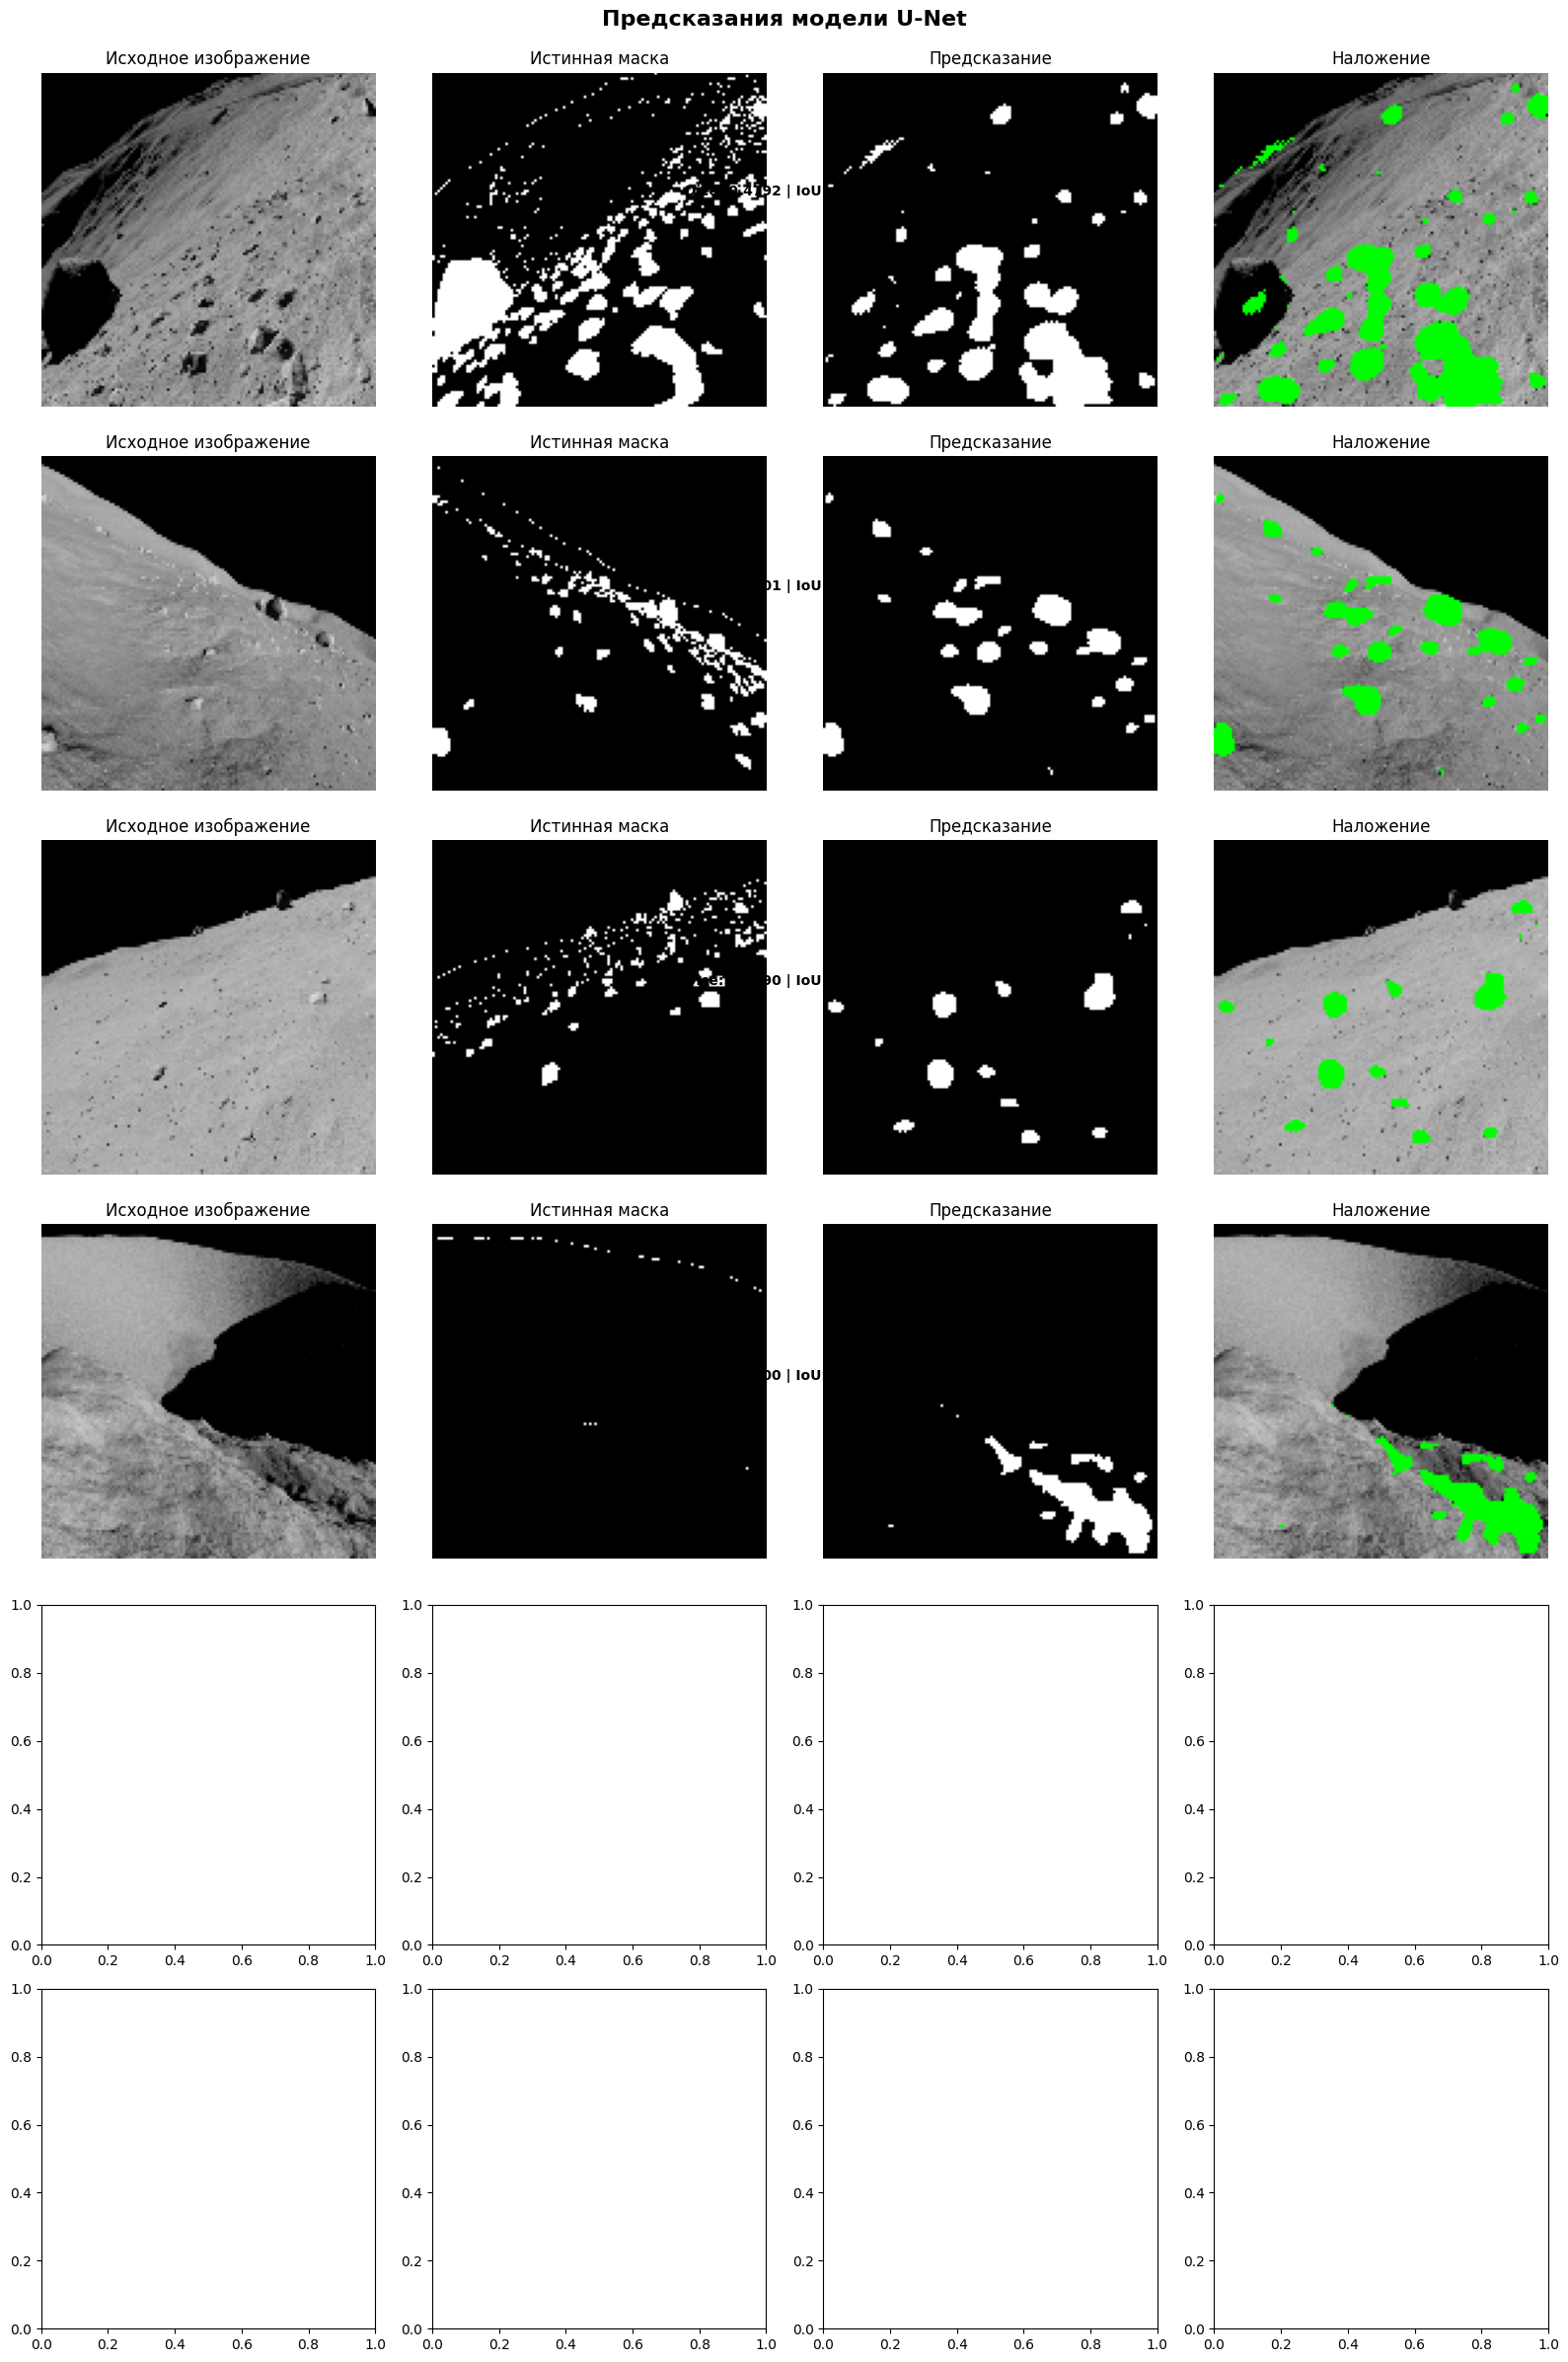

In [85]:
best_model = UNet(in_channels=3, out_channels=1, features=[16, 32, 64, 128])

checkpoint = torch.load('best_moon_unet.pth', map_location=device)
best_model.load_state_dict(checkpoint['model_state_dict'])
best_model = best_model.to(device)

print(f"Эпоха: {checkpoint['epoch'] + 1}")
print(f"Val Dice: {checkpoint['val_dice']:.4f}")
print(f"Val IoU: {checkpoint['val_iou']:.4f}")

visualize_predictions(best_model, val_loader, device, num_samples=6)


In [86]:
def predict_image(model, image_path, device, threshold=0.5):

    model.eval()
    
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_image = image.copy()
    
    augmented = val_augmentation(image=image)
    image = augmented['image']
    preprocessed = preprocessing(image=image)
    image_tensor = preprocessed['image'].unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(image_tensor)
        prediction = torch.sigmoid(output)
        prediction = (prediction > threshold).float()
    
    prediction = prediction.cpu().squeeze().numpy()
    
    return prediction, original_image


def visualize_single_prediction(image_path, prediction, original_image):

    overlay = cv2.resize(original_image, (prediction.shape[1], prediction.shape[0]))
    overlay = overlay.astype(float) / 255.0
    overlay[:, :, 1] = np.where(prediction > 0.5, 1, overlay[:, :, 1])
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(original_image)
    axes[0].set_title('Исходное изображение', fontsize=12, fontweight='bold')
    axes[0].axis('off')
    
    axes[1].imshow(prediction, cmap='gray')
    axes[1].set_title('Предсказание модели', fontsize=12, fontweight='bold')
    axes[1].axis('off')
    
    axes[2].imshow(overlay)
    axes[2].set_title('Наложение', fontsize=12, fontweight='bold')
    axes[2].axis('off')
    
    plt.suptitle(f'Инференс: {os.path.basename(image_path)}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


random_image_id = np.random.choice(val_ids)
image_path = os.path.join(DATA_ROOT, 'images', 'render', f'{random_image_id}.png')

prediction, original_image = predict_image(best_model, image_path, device)
visualize_single_prediction(image_path, prediction, original_image)


## Часть 2: U-Net с ResNet18 Backbone

Теперь создадим более мощную версию U-Net, используя предобученную ResNet18 как энкодер (backbone).



Далее с моделями мне помогал мой незаменимый коллега - чат ГПТ 5

In [155]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MyUNetFreeze_SimpleResNet32B(nn.Module):
    """
    U-Net (4 down / 4 up) + backbone encoder from SimpleResNet_32B (до avgpool/fc).

    Encoder:
      e1: conv1+bn1+relu                          -> [B,  64, 128,128]
      e2: maxpool + block1_0 + block1_1          -> [B,  64,  64, 64]
      e3: block2_0 + block2_1 (stride=2 в 2_0)   -> [B, 128,  32, 32]
      e4: block3_0 + block3_1 (stride=2 в 3_0)   -> [B, 256,  16, 16]
      bridge_down (добавлен 4-й down)            -> [B, 512,   8,  8]

    Decoder:
      8->16->32->64->128 + skip connections
    Output:
      logits [B, out_channels, 128, 128] (без sigmoid)
    """

    def __init__(self, num_classes_backbone, ckpt_path, out_channels=1, freeze_all=True, device="cpu"):
        super().__init__()
        self.freeze_all = freeze_all

        # --- load backbone weights ---
        backbone = SimpleResNet_32B(num_classes=num_classes_backbone).to(device)
        state = torch.load(ckpt_path, map_location=device)
        if isinstance(state, dict) and "model_state_dict" in state:
            backbone.load_state_dict(state["model_state_dict"])
        else:
            backbone.load_state_dict(state)

        self.backbone = backbone  # (необязательно, но полезно для отладки)

        # --- encoder stages (до avgpool/fc) ---
        self.encoder1 = nn.Sequential(backbone.conv1, backbone.bn1, backbone.relu)  # 64, 128x128
        self.pool = backbone.maxpool                                                # -> 64x64

        self.encoder2 = nn.Sequential(backbone.basic_block_1_0, backbone.basic_block_1_1)  # 64, 64x64
        self.encoder3 = nn.Sequential(backbone.basic_block_2_0, backbone.basic_block_2_1)  # 128, 32x32
        self.encoder4 = nn.Sequential(backbone.basic_block_3_0, backbone.basic_block_3_1)  # 256, 16x16

        # --- extra down to satisfy "4 down / 4 up" ---
        self.bridge_down = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1, bias=False),  # 16->8
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )

        # --- decoder ---
        self.up4 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)  # 8->16
        self.dec4 = DoubleConv(256 + 256, 256)

        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)  # 16->32
        self.dec3 = DoubleConv(128 + 128, 128)

        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)   # 32->64
        self.dec2 = DoubleConv(64 + 64, 64)

        self.up1 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)    # 64->128
        self.dec1 = DoubleConv(64 + 64, 64)

        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)        # logits

        # --- freeze for Variant A ---
        if self.freeze_all:
            self.freeze_encoder()

    def freeze_encoder(self):
        enc_modules = [self.encoder1, self.pool, self.encoder2, self.encoder3, self.encoder4]
        for m in enc_modules:
            for p in m.parameters():
                p.requires_grad = False

        # фиксируем BN статистики только для A
        self.encoder1.eval()
        self.encoder2.eval()
        self.encoder3.eval()
        self.encoder4.eval()

    def unfreeze_encoder(self):
        enc_modules = [self.encoder1, self.pool, self.encoder2, self.encoder3, self.encoder4]
        for m in enc_modules:
            for p in m.parameters():
                p.requires_grad = True

        # для B можно обучать BN (если хочешь BN frozen — скажи, дам вариант)
        self.encoder1.train()
        self.encoder2.train()
        self.encoder3.train()
        self.encoder4.train()

    def set_freeze(self, freeze: bool):
        """Удобный переключатель режима A/B."""
        self.freeze_all = freeze
        if freeze:
            self.freeze_encoder()
        else:
            self.unfreeze_encoder()

    def train(self, mode: bool = True):
        super().train(mode)

        # Вариант A: энкодер всегда eval, Вариант B: обычный train
        if self.freeze_all:
            self.encoder1.eval()
            self.encoder2.eval()
            self.encoder3.eval()
            self.encoder4.eval()

        return self

    def forward(self, x):
        # Encoder: A -> no_grad, B -> gradients enabled
        if self.freeze_all:
            with torch.no_grad():
                e1 = self.encoder1(x)     # [B,64,128,128]
                x2 = self.pool(e1)        # [B,64,64,64]
                e2 = self.encoder2(x2)    # [B,64,64,64]
                e3 = self.encoder3(e2)    # [B,128,32,32]
                e4 = self.encoder4(e3)    # [B,256,16,16]
        else:
            e1 = self.encoder1(x)
            x2 = self.pool(e1)
            e2 = self.encoder2(x2)
            e3 = self.encoder3(e2)
            e4 = self.encoder4(e3)

        # bridge
        b = self.bridge_down(e4)          # [B,512,8,8]

        # decoder with safe size matching
        d4 = self.up4(b)                  # [B,256,16,16]
        if d4.shape[-2:] != e4.shape[-2:]:
            d4 = F.interpolate(d4, size=e4.shape[-2:], mode="bilinear", align_corners=False)
        d4 = self.dec4(torch.cat([d4, e4], dim=1))

        d3 = self.up3(d4)                 # [B,128,32,32]
        if d3.shape[-2:] != e3.shape[-2:]:
            d3 = F.interpolate(d3, size=e3.shape[-2:], mode="bilinear", align_corners=False)
        d3 = self.dec3(torch.cat([d3, e3], dim=1))

        d2 = self.up2(d3)                 # [B,64,64,64]
        if d2.shape[-2:] != e2.shape[-2:]:
            d2 = F.interpolate(d2, size=e2.shape[-2:], mode="bilinear", align_corners=False)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))

        d1 = self.up1(d2)                 # [B,64,128,128]
        if d1.shape[-2:] != e1.shape[-2:]:
            d1 = F.interpolate(d1, size=e1.shape[-2:], mode="bilinear", align_corners=False)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        logits = self.out_conv(d1)        # [B,out_channels,128,128]
        return logits


In [156]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = MyUNetFreeze_SimpleResNet32B(
    num_classes_backbone=10,
    ckpt_path="best_model.pth",
    out_channels=1,
    freeze_all=True,
    device=device
).to(device)

x = torch.randn(1, 3, 128, 128).to(device)
y = model(x)
print("in:", x.shape, "out:", y.shape)

total = sum(p.numel() for p in model.parameters())
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"total params: {total:,}")
print(f"trainable params: {trainable:,}")


in: torch.Size([1, 3, 128, 128]) out: torch.Size([1, 1, 128, 128])
total params: 9,461,003
trainable params: 6,683,723


#### Вариант A


In [146]:
my_model_freeze_all = MyUNetFreeze_SimpleResNet32B(
    num_classes_backbone=10,
    ckpt_path="best_model.pth",
    out_channels=1,
    freeze_all=True,
    device=device
).to(device)

my_model_criterion = CombinedLoss(bce_weight=0.5, dice_weight=0.5)

encoder_params = []
decoder_params = []

for name, param in my_model_freeze_all.named_parameters():
    if name.startswith("encoder") or name.startswith("backbone") or name.startswith("pool"):
        encoder_params.append(param)
    else:
        decoder_params.append(param)

# --- ВАЖНО: в Variant A энкодер заморожен, поэтому:
# либо вообще НЕ добавляем его в оптимизатор,
# либо добавляем с lr=0 (как “по образцу”)
my_optimizer = torch.optim.Adam([
    {'params': [p for p in encoder_params if p.requires_grad], 'lr': 0.0},
    {'params': [p for p in decoder_params if p.requires_grad], 'lr': 1e-3},
])

# Проверки (очень советую оставить хотя бы на 1 запуск)
n_enc = sum(p.numel() for p in encoder_params)
n_dec = sum(p.numel() for p in decoder_params)
n_train = sum(p.numel() for p in my_model_freeze_all.parameters() if p.requires_grad)

print(f"Всего encoder params: {n_enc:,}")
print(f"Всего decoder params: {n_dec:,}")
print(f"Trainable params (должны быть > 0): {n_train:,}")

assert n_train > 0, "У модели нет обучаемых параметров — optimizer будет делать 'ничего'."

my_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    my_optimizer,
    T_0=10,
    T_mult=2,
    eta_min=1e-6
)

NUM_EPOCHS = 100
SAVE_PATH_FREEZE_ALL = 'best_unet_backbone_freeze_all.pth'

print(f"   Эпох: {NUM_EPOCHS}")
print(f"   Encoder LR: 0.0 (frozen)")
print(f"   Decoder LR: 1e-3")
print(f"   Модель будет сохранена в: {SAVE_PATH_FREEZE_ALL}")

my_history_freeze_all = train_model(
    model=my_model_freeze_all,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=my_model_criterion,
    optimizer=my_optimizer,
    scheduler=my_scheduler,
    num_epochs=NUM_EPOCHS,
    device=device,
    save_path=SAVE_PATH_FREEZE_ALL
)


Всего encoder params: 2,779,850
Всего decoder params: 6,681,153
Trainable params (должны быть > 0): 6,683,723
   Эпох: 100
   Encoder LR: 0.0 (frozen)
   Decoder LR: 1e-3
   Модель будет сохранена в: best_unet_backbone_freeze_all.pth
Эпоха 1/100


Training:   0%|          | 0/20 [00:00<?, ?it/s]/Users/andrey_kiseleq/Documents/vs_code/itmo/arc_ml/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Validation: 100%|██████████| 5/5 [00:00<00:00,  5.53it/s, loss=0.5939, dice=0.4039, iou=0.2531, acc=0.8354]



 Результаты эпохи 1:
  Train - Loss: 0.6537, Dice: 0.3412, IoU: 0.2109
  Val   - Loss: 0.6093, Dice: 0.3951, IoU: 0.2482, Acc: 0.8116
  LR: 0.000000
  Сохранена лучшая модель! Dice: 0.3951
Эпоха 2/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.53it/s, loss=0.5430, dice=0.4311, iou=0.2748, acc=0.8846]



 Результаты эпохи 2:
  Train - Loss: 0.5644, Dice: 0.3879, IoU: 0.2478
  Val   - Loss: 0.5365, Dice: 0.4639, IoU: 0.3045, Acc: 0.8884
  LR: 0.000000
  Сохранена лучшая модель! Dice: 0.4639
Эпоха 3/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.64it/s, loss=0.5471, dice=0.4032, iou=0.2525, acc=0.8767]



 Результаты эпохи 3:
  Train - Loss: 0.5229, Dice: 0.3961, IoU: 0.2496
  Val   - Loss: 0.5569, Dice: 0.3963, IoU: 0.2505, Acc: 0.8607
  LR: 0.000000
Эпоха 4/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.63it/s, loss=0.4550, dice=0.4952, iou=0.3291, acc=0.9090]



 Результаты эпохи 4:
  Train - Loss: 0.5162, Dice: 0.3652, IoU: 0.2276
  Val   - Loss: 0.4668, Dice: 0.4740, IoU: 0.3131, Acc: 0.8991
  LR: 0.000000
  Сохранена лучшая модель! Dice: 0.4740
Эпоха 5/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.61it/s, loss=0.4754, dice=0.3622, iou=0.2212, acc=0.9187]



 Результаты эпохи 5:
  Train - Loss: 0.5150, Dice: 0.3393, IoU: 0.2113
  Val   - Loss: 0.4770, Dice: 0.3923, IoU: 0.2469, Acc: 0.9133
  LR: 0.000000
Эпоха 6/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.41it/s, loss=0.4524, dice=0.4016, iou=0.2512, acc=0.9092]



 Результаты эпохи 6:
  Train - Loss: 0.4944, Dice: 0.3596, IoU: 0.2225
  Val   - Loss: 0.4481, Dice: 0.4341, IoU: 0.2817, Acc: 0.9035
  LR: 0.000000
Эпоха 7/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.66it/s, loss=0.4396, dice=0.4395, iou=0.2817, acc=0.9033]



 Результаты эпохи 7:
  Train - Loss: 0.4869, Dice: 0.3669, IoU: 0.2291
  Val   - Loss: 0.4371, Dice: 0.4690, IoU: 0.3106, Acc: 0.8963
  LR: 0.000000
Эпоха 8/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.30it/s, loss=0.4239, dice=0.4498, iou=0.2902, acc=0.9194]



 Результаты эпохи 8:
  Train - Loss: 0.4728, Dice: 0.3993, IoU: 0.2531
  Val   - Loss: 0.4283, Dice: 0.4710, IoU: 0.3103, Acc: 0.9116
  LR: 0.000000
Эпоха 9/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.34it/s, loss=0.4386, dice=0.4492, iou=0.2897, acc=0.9122]



 Результаты эпохи 9:
  Train - Loss: 0.4641, Dice: 0.4110, IoU: 0.2607
  Val   - Loss: 0.4373, Dice: 0.4732, IoU: 0.3121, Acc: 0.9065
  LR: 0.000000
Эпоха 10/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.44it/s, loss=0.4446, dice=0.4288, iou=0.2729, acc=0.8998]



 Результаты эпохи 10:
  Train - Loss: 0.4710, Dice: 0.3810, IoU: 0.2430
  Val   - Loss: 0.4404, Dice: 0.4495, IoU: 0.2931, Acc: 0.9006
  LR: 0.000000
Эпоха 11/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.39it/s, loss=0.4590, dice=0.4477, iou=0.2884, acc=0.8696]



 Результаты эпохи 11:
  Train - Loss: 0.4626, Dice: 0.4009, IoU: 0.2566
  Val   - Loss: 0.4779, Dice: 0.4468, IoU: 0.2900, Acc: 0.8503
  LR: 0.000000
Эпоха 12/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.28it/s, loss=0.4006, dice=0.5013, iou=0.3345, acc=0.9125]



 Результаты эпохи 12:
  Train - Loss: 0.4467, Dice: 0.4420, IoU: 0.2873
  Val   - Loss: 0.4206, Dice: 0.4882, IoU: 0.3263, Acc: 0.9007
  LR: 0.000000
  Сохранена лучшая модель! Dice: 0.4882
Эпоха 13/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.44it/s, loss=0.4454, dice=0.3787, iou=0.2336, acc=0.9186]



 Результаты эпохи 13:
  Train - Loss: 0.4728, Dice: 0.3801, IoU: 0.2416
  Val   - Loss: 0.4356, Dice: 0.4238, IoU: 0.2715, Acc: 0.9147
  LR: 0.000000
Эпоха 14/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.60it/s, loss=0.4183, dice=0.4597, iou=0.2985, acc=0.9197]



 Результаты эпохи 14:
  Train - Loss: 0.4781, Dice: 0.3771, IoU: 0.2376
  Val   - Loss: 0.4242, Dice: 0.4769, IoU: 0.3161, Acc: 0.9142
  LR: 0.000000
Эпоха 15/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.82it/s, loss=0.4035, dice=0.4788, iou=0.3147, acc=0.9165]



 Результаты эпохи 15:
  Train - Loss: 0.4493, Dice: 0.4215, IoU: 0.2719
  Val   - Loss: 0.4082, Dice: 0.4997, IoU: 0.3354, Acc: 0.9106
  LR: 0.000000
  Сохранена лучшая модель! Dice: 0.4997
Эпоха 16/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.51it/s, loss=0.3988, dice=0.4764, iou=0.3127, acc=0.9204]



 Результаты эпохи 16:
  Train - Loss: 0.4446, Dice: 0.4336, IoU: 0.2804
  Val   - Loss: 0.4097, Dice: 0.4872, IoU: 0.3249, Acc: 0.9139
  LR: 0.000000
Эпоха 17/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.48it/s, loss=0.4443, dice=0.4656, iou=0.3034, acc=0.8819]



 Результаты эпохи 17:
  Train - Loss: 0.4532, Dice: 0.4232, IoU: 0.2739
  Val   - Loss: 0.4539, Dice: 0.4744, IoU: 0.3151, Acc: 0.8729
  LR: 0.000000
Эпоха 18/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.69it/s, loss=0.3965, dice=0.5154, iou=0.3471, acc=0.9150]



 Результаты эпохи 18:
  Train - Loss: 0.4621, Dice: 0.4049, IoU: 0.2609
  Val   - Loss: 0.4089, Dice: 0.5124, IoU: 0.3471, Acc: 0.9077
  LR: 0.000000
  Сохранена лучшая модель! Dice: 0.5124
Эпоха 19/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.59it/s, loss=0.4140, dice=0.4754, iou=0.3118, acc=0.9010]



 Результаты эпохи 19:
  Train - Loss: 0.4514, Dice: 0.4252, IoU: 0.2725
  Val   - Loss: 0.4296, Dice: 0.4785, IoU: 0.3194, Acc: 0.8897
  LR: 0.000000
Эпоха 20/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.60it/s, loss=0.4145, dice=0.4705, iou=0.3076, acc=0.9061]



 Результаты эпохи 20:
  Train - Loss: 0.4653, Dice: 0.3890, IoU: 0.2456
  Val   - Loss: 0.4141, Dice: 0.5000, IoU: 0.3373, Acc: 0.9017
  LR: 0.000000
Эпоха 21/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.38it/s, loss=0.4055, dice=0.4860, iou=0.3210, acc=0.9165]



 Результаты эпохи 21:
  Train - Loss: 0.4737, Dice: 0.3755, IoU: 0.2360
  Val   - Loss: 0.4083, Dice: 0.5050, IoU: 0.3412, Acc: 0.9079
  LR: 0.000000
Эпоха 22/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.46it/s, loss=0.3938, dice=0.4914, iou=0.3257, acc=0.9178]



 Результаты эпохи 22:
  Train - Loss: 0.4510, Dice: 0.4240, IoU: 0.2768
  Val   - Loss: 0.4037, Dice: 0.5022, IoU: 0.3390, Acc: 0.9057
  LR: 0.000000
Эпоха 23/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.48it/s, loss=0.3910, dice=0.4943, iou=0.3283, acc=0.9179]



 Результаты эпохи 23:
  Train - Loss: 0.4551, Dice: 0.4166, IoU: 0.2697
  Val   - Loss: 0.4085, Dice: 0.4989, IoU: 0.3372, Acc: 0.9067
  LR: 0.000000
Эпоха 24/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.46it/s, loss=0.4190, dice=0.4715, iou=0.3085, acc=0.8967]



 Результаты эпохи 24:
  Train - Loss: 0.4616, Dice: 0.3962, IoU: 0.2530
  Val   - Loss: 0.4239, Dice: 0.4899, IoU: 0.3278, Acc: 0.8906
  LR: 0.000000
Эпоха 25/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.41it/s, loss=0.4221, dice=0.4330, iou=0.2763, acc=0.9235]



 Результаты эпохи 25:
  Train - Loss: 0.4520, Dice: 0.4294, IoU: 0.2780
  Val   - Loss: 0.4131, Dice: 0.4820, IoU: 0.3212, Acc: 0.9194
  LR: 0.000000
Эпоха 26/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.38it/s, loss=0.4112, dice=0.4980, iou=0.3316, acc=0.8872]



 Результаты эпохи 26:
  Train - Loss: 0.4542, Dice: 0.4080, IoU: 0.2596
  Val   - Loss: 0.4372, Dice: 0.4850, IoU: 0.3244, Acc: 0.8695
  LR: 0.000000
Эпоха 27/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.74it/s, loss=0.4275, dice=0.4244, iou=0.2694, acc=0.9158]



 Результаты эпохи 27:
  Train - Loss: 0.4450, Dice: 0.4259, IoU: 0.2751
  Val   - Loss: 0.4060, Dice: 0.4886, IoU: 0.3273, Acc: 0.9128
  LR: 0.000000
Эпоха 28/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.51it/s, loss=0.4071, dice=0.4462, iou=0.2871, acc=0.9247]



 Результаты эпохи 28:
  Train - Loss: 0.4511, Dice: 0.4158, IoU: 0.2673
  Val   - Loss: 0.4052, Dice: 0.4903, IoU: 0.3280, Acc: 0.9176
  LR: 0.000000
Эпоха 29/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.36it/s, loss=0.4102, dice=0.4676, iou=0.3051, acc=0.9182]



 Результаты эпохи 29:
  Train - Loss: 0.4446, Dice: 0.4252, IoU: 0.2747
  Val   - Loss: 0.4030, Dice: 0.5011, IoU: 0.3373, Acc: 0.9146
  LR: 0.000000
Эпоха 30/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.33it/s, loss=0.4166, dice=0.4803, iou=0.3161, acc=0.8911]



 Результаты эпохи 30:
  Train - Loss: 0.4573, Dice: 0.4071, IoU: 0.2579
  Val   - Loss: 0.4346, Dice: 0.4818, IoU: 0.3217, Acc: 0.8808
  LR: 0.000000
Эпоха 31/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.55it/s, loss=0.4061, dice=0.4670, iou=0.3046, acc=0.9218]



 Результаты эпохи 31:
  Train - Loss: 0.4525, Dice: 0.4160, IoU: 0.2687
  Val   - Loss: 0.4017, Dice: 0.5009, IoU: 0.3373, Acc: 0.9151
  LR: 0.000000
Эпоха 32/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.53it/s, loss=0.4098, dice=0.4705, iou=0.3076, acc=0.9163]



 Результаты эпохи 32:
  Train - Loss: 0.4407, Dice: 0.4367, IoU: 0.2861
  Val   - Loss: 0.4027, Dice: 0.5110, IoU: 0.3459, Acc: 0.9133
  LR: 0.000000
Эпоха 33/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.78it/s, loss=0.3911, dice=0.5038, iou=0.3367, acc=0.9120]



 Результаты эпохи 33:
  Train - Loss: 0.4291, Dice: 0.4526, IoU: 0.2974
  Val   - Loss: 0.4006, Dice: 0.5121, IoU: 0.3474, Acc: 0.9027
  LR: 0.000000
Эпоха 34/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.52it/s, loss=0.4128, dice=0.4405, iou=0.2825, acc=0.9240]



 Результаты эпохи 34:
  Train - Loss: 0.4425, Dice: 0.4191, IoU: 0.2734
  Val   - Loss: 0.4011, Dice: 0.4888, IoU: 0.3267, Acc: 0.9199
  LR: 0.000000
Эпоха 35/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.67it/s, loss=0.3958, dice=0.5089, iou=0.3413, acc=0.9083]



 Результаты эпохи 35:
  Train - Loss: 0.4559, Dice: 0.3984, IoU: 0.2530
  Val   - Loss: 0.4065, Dice: 0.5161, IoU: 0.3518, Acc: 0.8990
  LR: 0.000000
  Сохранена лучшая модель! Dice: 0.5161
Эпоха 36/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.64it/s, loss=0.4259, dice=0.4846, iou=0.3198, acc=0.8822]



 Результаты эпохи 36:
  Train - Loss: 0.4417, Dice: 0.4268, IoU: 0.2754
  Val   - Loss: 0.4313, Dice: 0.4960, IoU: 0.3342, Acc: 0.8780
  LR: 0.000000
Эпоха 37/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.73it/s, loss=0.3858, dice=0.5223, iou=0.3534, acc=0.9181]



 Результаты эпохи 37:
  Train - Loss: 0.4382, Dice: 0.4369, IoU: 0.2838
  Val   - Loss: 0.4000, Dice: 0.5233, IoU: 0.3576, Acc: 0.9080
  LR: 0.000000
  Сохранена лучшая модель! Dice: 0.5233
Эпоха 38/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.52it/s, loss=0.3846, dice=0.5038, iou=0.3367, acc=0.9194]



 Результаты эпохи 38:
  Train - Loss: 0.4310, Dice: 0.4581, IoU: 0.3024
  Val   - Loss: 0.3913, Dice: 0.5188, IoU: 0.3541, Acc: 0.9131
  LR: 0.000000
Эпоха 39/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.58it/s, loss=0.3942, dice=0.4986, iou=0.3321, acc=0.9209]



 Результаты эпохи 39:
  Train - Loss: 0.4544, Dice: 0.4131, IoU: 0.2658
  Val   - Loss: 0.3904, Dice: 0.5284, IoU: 0.3622, Acc: 0.9157
  LR: 0.000000
  Сохранена лучшая модель! Dice: 0.5284
Эпоха 40/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.60it/s, loss=0.3902, dice=0.5197, iou=0.3511, acc=0.8973]



 Результаты эпохи 40:
  Train - Loss: 0.4529, Dice: 0.4085, IoU: 0.2607
  Val   - Loss: 0.4345, Dice: 0.4871, IoU: 0.3263, Acc: 0.8745
  LR: 0.000000
Эпоха 41/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.55it/s, loss=0.3936, dice=0.5148, iou=0.3466, acc=0.9055]



 Результаты эпохи 41:
  Train - Loss: 0.4352, Dice: 0.4385, IoU: 0.2853
  Val   - Loss: 0.4091, Dice: 0.5102, IoU: 0.3461, Acc: 0.8941
  LR: 0.000000
Эпоха 42/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.59it/s, loss=0.3843, dice=0.4875, iou=0.3224, acc=0.9240]



 Результаты эпохи 42:
  Train - Loss: 0.4523, Dice: 0.4157, IoU: 0.2692
  Val   - Loss: 0.3938, Dice: 0.5045, IoU: 0.3418, Acc: 0.9135
  LR: 0.000000
Эпоха 43/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.48it/s, loss=0.3874, dice=0.4964, iou=0.3301, acc=0.9263]



 Результаты эпохи 43:
  Train - Loss: 0.4235, Dice: 0.4536, IoU: 0.2992
  Val   - Loss: 0.3890, Dice: 0.5203, IoU: 0.3550, Acc: 0.9189
  LR: 0.000000
Эпоха 44/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.52it/s, loss=0.3666, dice=0.5360, iou=0.3661, acc=0.9258]



 Результаты эпохи 44:
  Train - Loss: 0.4400, Dice: 0.4362, IoU: 0.2843
  Val   - Loss: 0.3916, Dice: 0.5261, IoU: 0.3604, Acc: 0.9062
  LR: 0.000000
Эпоха 45/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.48it/s, loss=0.4071, dice=0.4753, iou=0.3118, acc=0.9260]



 Результаты эпохи 45:
  Train - Loss: 0.4396, Dice: 0.4378, IoU: 0.2880
  Val   - Loss: 0.3996, Dice: 0.5088, IoU: 0.3451, Acc: 0.9154
  LR: 0.000000
Эпоха 46/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.64it/s, loss=0.4097, dice=0.4642, iou=0.3023, acc=0.9197]



 Результаты эпохи 46:
  Train - Loss: 0.4610, Dice: 0.4055, IoU: 0.2599
  Val   - Loss: 0.3950, Dice: 0.5081, IoU: 0.3441, Acc: 0.9151
  LR: 0.000000
Эпоха 47/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.36it/s, loss=0.3965, dice=0.4933, iou=0.3274, acc=0.9107]



 Результаты эпохи 47:
  Train - Loss: 0.4405, Dice: 0.4419, IoU: 0.2886
  Val   - Loss: 0.4137, Dice: 0.4979, IoU: 0.3358, Acc: 0.8938
  LR: 0.000000
Эпоха 48/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.45it/s, loss=0.4099, dice=0.4511, iou=0.2913, acc=0.9217]



 Результаты эпохи 48:
  Train - Loss: 0.4329, Dice: 0.4419, IoU: 0.2893
  Val   - Loss: 0.3978, Dice: 0.4997, IoU: 0.3374, Acc: 0.9168
  LR: 0.000000
Эпоха 49/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.75it/s, loss=0.3942, dice=0.4728, iou=0.3096, acc=0.9158]



 Результаты эпохи 49:
  Train - Loss: 0.4289, Dice: 0.4477, IoU: 0.2927
  Val   - Loss: 0.3974, Dice: 0.5064, IoU: 0.3435, Acc: 0.9057
  LR: 0.000000
Эпоха 50/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.39it/s, loss=0.3899, dice=0.4928, iou=0.3269, acc=0.9263]



 Результаты эпохи 50:
  Train - Loss: 0.4315, Dice: 0.4496, IoU: 0.2949
  Val   - Loss: 0.3909, Dice: 0.5186, IoU: 0.3536, Acc: 0.9169
  LR: 0.000000
Эпоха 51/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.48it/s, loss=0.3696, dice=0.5288, iou=0.3594, acc=0.9183]



 Результаты эпохи 51:
  Train - Loss: 0.4429, Dice: 0.4302, IoU: 0.2797
  Val   - Loss: 0.3990, Dice: 0.5094, IoU: 0.3464, Acc: 0.9010
  LR: 0.000000
Эпоха 52/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.35it/s, loss=0.3840, dice=0.5077, iou=0.3402, acc=0.9156]



 Результаты эпохи 52:
  Train - Loss: 0.4343, Dice: 0.4458, IoU: 0.2946
  Val   - Loss: 0.3989, Dice: 0.5131, IoU: 0.3494, Acc: 0.9040
  LR: 0.000000
Эпоха 53/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.35it/s, loss=0.4000, dice=0.4782, iou=0.3143, acc=0.9230]



 Результаты эпохи 53:
  Train - Loss: 0.4566, Dice: 0.4034, IoU: 0.2570
  Val   - Loss: 0.3921, Dice: 0.5174, IoU: 0.3526, Acc: 0.9163
  LR: 0.000000
Эпоха 54/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.75it/s, loss=0.3844, dice=0.5011, iou=0.3343, acc=0.9242]



 Результаты эпохи 54:
  Train - Loss: 0.4350, Dice: 0.4314, IoU: 0.2828
  Val   - Loss: 0.3856, Dice: 0.5168, IoU: 0.3529, Acc: 0.9158
  LR: 0.000000
Эпоха 55/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.50it/s, loss=0.3936, dice=0.4948, iou=0.3288, acc=0.9148]



 Результаты эпохи 55:
  Train - Loss: 0.4350, Dice: 0.4390, IoU: 0.2863
  Val   - Loss: 0.3990, Dice: 0.5095, IoU: 0.3462, Acc: 0.9016
  LR: 0.000000
Эпоха 56/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.72it/s, loss=0.4071, dice=0.4607, iou=0.2993, acc=0.9135]



 Результаты эпохи 56:
  Train - Loss: 0.4486, Dice: 0.4199, IoU: 0.2700
  Val   - Loss: 0.3964, Dice: 0.5083, IoU: 0.3459, Acc: 0.9101
  LR: 0.000000
Эпоха 57/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.46it/s, loss=0.3985, dice=0.4834, iou=0.3187, acc=0.9156]



 Результаты эпохи 57:
  Train - Loss: 0.4445, Dice: 0.4303, IoU: 0.2791
  Val   - Loss: 0.3902, Dice: 0.5213, IoU: 0.3568, Acc: 0.9099
  LR: 0.000000
Эпоха 58/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.40it/s, loss=0.3904, dice=0.4887, iou=0.3233, acc=0.9191]



 Результаты эпохи 58:
  Train - Loss: 0.4442, Dice: 0.4137, IoU: 0.2644
  Val   - Loss: 0.3924, Dice: 0.5169, IoU: 0.3530, Acc: 0.9073
  LR: 0.000000
Эпоха 59/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.42it/s, loss=0.3969, dice=0.4721, iou=0.3090, acc=0.9208]



 Результаты эпохи 59:
  Train - Loss: 0.4468, Dice: 0.4185, IoU: 0.2710
  Val   - Loss: 0.3908, Dice: 0.5084, IoU: 0.3449, Acc: 0.9145
  LR: 0.000000
Эпоха 60/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.28it/s, loss=0.4010, dice=0.4476, iou=0.2883, acc=0.9262]



 Результаты эпохи 60:
  Train - Loss: 0.4221, Dice: 0.4542, IoU: 0.3017
  Val   - Loss: 0.3934, Dice: 0.4921, IoU: 0.3303, Acc: 0.9210
  LR: 0.000000
Эпоха 61/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.41it/s, loss=0.3715, dice=0.5276, iou=0.3583, acc=0.9254]



 Результаты эпохи 61:
  Train - Loss: 0.4287, Dice: 0.4428, IoU: 0.2893
  Val   - Loss: 0.3907, Dice: 0.5208, IoU: 0.3552, Acc: 0.9105
  LR: 0.000000
Эпоха 62/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.26it/s, loss=0.3905, dice=0.4970, iou=0.3306, acc=0.9180]



 Результаты эпохи 62:
  Train - Loss: 0.4276, Dice: 0.4431, IoU: 0.2930
  Val   - Loss: 0.3844, Dice: 0.5361, IoU: 0.3693, Acc: 0.9145
  LR: 0.000000
  Сохранена лучшая модель! Dice: 0.5361
Эпоха 63/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.56it/s, loss=0.3694, dice=0.5383, iou=0.3683, acc=0.9146]



 Результаты эпохи 63:
  Train - Loss: 0.4145, Dice: 0.4748, IoU: 0.3154
  Val   - Loss: 0.3850, Dice: 0.5353, IoU: 0.3694, Acc: 0.9023
  LR: 0.000000
Эпоха 64/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.20it/s, loss=0.3805, dice=0.5038, iou=0.3367, acc=0.9275]



 Результаты эпохи 64:
  Train - Loss: 0.4288, Dice: 0.4466, IoU: 0.2953
  Val   - Loss: 0.3833, Dice: 0.5261, IoU: 0.3595, Acc: 0.9215
  LR: 0.000000
Эпоха 65/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.32it/s, loss=0.3774, dice=0.5067, iou=0.3393, acc=0.9262]



 Результаты эпохи 65:
  Train - Loss: 0.4385, Dice: 0.4284, IoU: 0.2775
  Val   - Loss: 0.3839, Dice: 0.5238, IoU: 0.3577, Acc: 0.9187
  LR: 0.000000
Эпоха 66/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.20it/s, loss=0.3804, dice=0.5310, iou=0.3615, acc=0.9156]



 Результаты эпохи 66:
  Train - Loss: 0.4378, Dice: 0.4266, IoU: 0.2774
  Val   - Loss: 0.3980, Dice: 0.5201, IoU: 0.3562, Acc: 0.9004
  LR: 0.000000
Эпоха 67/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.47it/s, loss=0.4228, dice=0.4743, iou=0.3108, acc=0.8958]



 Результаты эпохи 67:
  Train - Loss: 0.4537, Dice: 0.4067, IoU: 0.2618
  Val   - Loss: 0.4166, Dice: 0.5077, IoU: 0.3449, Acc: 0.8934
  LR: 0.000000
Эпоха 68/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.48it/s, loss=0.3858, dice=0.4871, iou=0.3220, acc=0.9218]



 Результаты эпохи 68:
  Train - Loss: 0.4202, Dice: 0.4679, IoU: 0.3080
  Val   - Loss: 0.3877, Dice: 0.5147, IoU: 0.3505, Acc: 0.9159
  LR: 0.000000
Эпоха 69/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.32it/s, loss=0.3902, dice=0.4644, iou=0.3024, acc=0.9258]



 Результаты эпохи 69:
  Train - Loss: 0.4421, Dice: 0.4289, IoU: 0.2819
  Val   - Loss: 0.3860, Dice: 0.5078, IoU: 0.3441, Acc: 0.9182
  LR: 0.000000
Эпоха 70/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.48it/s, loss=0.3819, dice=0.4970, iou=0.3307, acc=0.9258]



 Результаты эпохи 70:
  Train - Loss: 0.4404, Dice: 0.4310, IoU: 0.2800
  Val   - Loss: 0.3803, Dice: 0.5253, IoU: 0.3604, Acc: 0.9151
  LR: 0.000000
Эпоха 71/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.58it/s, loss=0.3855, dice=0.4964, iou=0.3302, acc=0.9164]



 Результаты эпохи 71:
  Train - Loss: 0.4186, Dice: 0.4700, IoU: 0.3116
  Val   - Loss: 0.4038, Dice: 0.5073, IoU: 0.3449, Acc: 0.9005
  LR: 0.000000
Эпоха 72/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.26it/s, loss=0.3810, dice=0.4939, iou=0.3280, acc=0.9237]



 Результаты эпохи 72:
  Train - Loss: 0.4349, Dice: 0.4318, IoU: 0.2802
  Val   - Loss: 0.3822, Dice: 0.5311, IoU: 0.3656, Acc: 0.9153
  LR: 0.000000
Эпоха 73/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.48it/s, loss=0.3834, dice=0.5163, iou=0.3480, acc=0.9190]



 Результаты эпохи 73:
  Train - Loss: 0.4260, Dice: 0.4465, IoU: 0.2908
  Val   - Loss: 0.3863, Dice: 0.5282, IoU: 0.3629, Acc: 0.9100
  LR: 0.000000
Эпоха 74/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.51it/s, loss=0.3605, dice=0.5256, iou=0.3565, acc=0.9286]



 Результаты эпохи 74:
  Train - Loss: 0.4292, Dice: 0.4434, IoU: 0.2884
  Val   - Loss: 0.3735, Dice: 0.5353, IoU: 0.3695, Acc: 0.9167
  LR: 0.000000
Эпоха 75/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.47it/s, loss=0.4196, dice=0.4160, iou=0.2626, acc=0.9225]



 Результаты эпохи 75:
  Train - Loss: 0.4273, Dice: 0.4627, IoU: 0.3045
  Val   - Loss: 0.4102, Dice: 0.4670, IoU: 0.3095, Acc: 0.9185
  LR: 0.000000
Эпоха 76/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.32it/s, loss=0.3704, dice=0.5399, iou=0.3698, acc=0.9189]



 Результаты эпохи 76:
  Train - Loss: 0.4244, Dice: 0.4561, IoU: 0.3032
  Val   - Loss: 0.3890, Dice: 0.5344, IoU: 0.3685, Acc: 0.9044
  LR: 0.000000
Эпоха 77/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.65it/s, loss=0.3682, dice=0.5069, iou=0.3395, acc=0.9233]



 Результаты эпохи 77:
  Train - Loss: 0.4132, Dice: 0.4663, IoU: 0.3097
  Val   - Loss: 0.3812, Dice: 0.5256, IoU: 0.3608, Acc: 0.9130
  LR: 0.000000
Эпоха 78/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.51it/s, loss=0.3710, dice=0.5121, iou=0.3442, acc=0.9288]



 Результаты эпохи 78:
  Train - Loss: 0.4166, Dice: 0.4692, IoU: 0.3127
  Val   - Loss: 0.3773, Dice: 0.5320, IoU: 0.3661, Acc: 0.9176
  LR: 0.000000
Эпоха 79/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.43it/s, loss=0.3767, dice=0.5092, iou=0.3415, acc=0.9235]



 Результаты эпохи 79:
  Train - Loss: 0.4212, Dice: 0.4530, IoU: 0.2966
  Val   - Loss: 0.3795, Dice: 0.5312, IoU: 0.3656, Acc: 0.9152
  LR: 0.000000
Эпоха 80/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.50it/s, loss=0.3812, dice=0.4793, iou=0.3152, acc=0.9250]



 Результаты эпохи 80:
  Train - Loss: 0.4316, Dice: 0.4448, IoU: 0.2927
  Val   - Loss: 0.3763, Dice: 0.5276, IoU: 0.3628, Acc: 0.9169
  LR: 0.000000
Эпоха 81/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.49it/s, loss=0.3861, dice=0.4872, iou=0.3221, acc=0.9219]



 Результаты эпохи 81:
  Train - Loss: 0.4417, Dice: 0.4252, IoU: 0.2781
  Val   - Loss: 0.3887, Dice: 0.5219, IoU: 0.3583, Acc: 0.9125
  LR: 0.000000
Эпоха 82/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.42it/s, loss=0.3936, dice=0.5117, iou=0.3438, acc=0.9050]



 Результаты эпохи 82:
  Train - Loss: 0.4091, Dice: 0.4748, IoU: 0.3164
  Val   - Loss: 0.4018, Dice: 0.5194, IoU: 0.3556, Acc: 0.8990
  LR: 0.000000
Эпоха 83/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.17it/s, loss=0.3755, dice=0.5028, iou=0.3359, acc=0.9240]



 Результаты эпохи 83:
  Train - Loss: 0.4339, Dice: 0.4285, IoU: 0.2794
  Val   - Loss: 0.3818, Dice: 0.5279, IoU: 0.3630, Acc: 0.9125
  LR: 0.000000
Эпоха 84/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.54it/s, loss=0.3747, dice=0.5071, iou=0.3396, acc=0.9254]



 Результаты эпохи 84:
  Train - Loss: 0.4410, Dice: 0.4336, IoU: 0.2826
  Val   - Loss: 0.3752, Dice: 0.5386, IoU: 0.3725, Acc: 0.9162
  LR: 0.000000
  Сохранена лучшая модель! Dice: 0.5386
Эпоха 85/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.24it/s, loss=0.3888, dice=0.5064, iou=0.3390, acc=0.9161]



 Результаты эпохи 85:
  Train - Loss: 0.4159, Dice: 0.4624, IoU: 0.3058
  Val   - Loss: 0.3857, Dice: 0.5350, IoU: 0.3695, Acc: 0.9076
  LR: 0.000000
Эпоха 86/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.19it/s, loss=0.3985, dice=0.4830, iou=0.3184, acc=0.9165]



 Результаты эпохи 86:
  Train - Loss: 0.4033, Dice: 0.4923, IoU: 0.3329
  Val   - Loss: 0.3803, Dice: 0.5312, IoU: 0.3657, Acc: 0.9133
  LR: 0.000000
Эпоха 87/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.34it/s, loss=0.4007, dice=0.4646, iou=0.3026, acc=0.9259]



 Результаты эпохи 87:
  Train - Loss: 0.4228, Dice: 0.4564, IoU: 0.3030
  Val   - Loss: 0.3947, Dice: 0.4990, IoU: 0.3368, Acc: 0.9221
  LR: 0.000000
Эпоха 88/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.42it/s, loss=0.3934, dice=0.4824, iou=0.3178, acc=0.9218]



 Результаты эпохи 88:
  Train - Loss: 0.4364, Dice: 0.4438, IoU: 0.2901
  Val   - Loss: 0.3862, Dice: 0.5221, IoU: 0.3576, Acc: 0.9142
  LR: 0.000000
Эпоха 89/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.27it/s, loss=0.3583, dice=0.5415, iou=0.3712, acc=0.9210]



 Результаты эпохи 89:
  Train - Loss: 0.4150, Dice: 0.4669, IoU: 0.3117
  Val   - Loss: 0.3811, Dice: 0.5383, IoU: 0.3729, Acc: 0.9055
  LR: 0.000000
Эпоха 90/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.38it/s, loss=0.3719, dice=0.4971, iou=0.3308, acc=0.9260]



 Результаты эпохи 90:
  Train - Loss: 0.4142, Dice: 0.4792, IoU: 0.3223
  Val   - Loss: 0.3718, Dice: 0.5333, IoU: 0.3673, Acc: 0.9195
  LR: 0.000000
Эпоха 91/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.49it/s, loss=0.3703, dice=0.5076, iou=0.3401, acc=0.9284]



 Результаты эпохи 91:
  Train - Loss: 0.4202, Dice: 0.4578, IoU: 0.3072
  Val   - Loss: 0.3684, Dice: 0.5445, IoU: 0.3775, Acc: 0.9191
  LR: 0.000000
  Сохранена лучшая модель! Dice: 0.5445
Эпоха 92/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.30it/s, loss=0.3675, dice=0.5429, iou=0.3726, acc=0.9213]



 Результаты эпохи 92:
  Train - Loss: 0.3925, Dice: 0.5057, IoU: 0.3453
  Val   - Loss: 0.3809, Dice: 0.5410, IoU: 0.3752, Acc: 0.9097
  LR: 0.000000
Эпоха 93/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.29it/s, loss=0.3693, dice=0.5394, iou=0.3693, acc=0.9156]



 Результаты эпохи 93:
  Train - Loss: 0.4203, Dice: 0.4625, IoU: 0.3061
  Val   - Loss: 0.4092, Dice: 0.5173, IoU: 0.3515, Acc: 0.8875
  LR: 0.000000
Эпоха 94/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.44it/s, loss=0.3887, dice=0.4563, iou=0.2956, acc=0.9267]



 Результаты эпохи 94:
  Train - Loss: 0.4053, Dice: 0.4843, IoU: 0.3258
  Val   - Loss: 0.3785, Dice: 0.5173, IoU: 0.3536, Acc: 0.9196
  LR: 0.000000
Эпоха 95/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.62it/s, loss=0.3528, dice=0.5334, iou=0.3637, acc=0.9301]



 Результаты эпохи 95:
  Train - Loss: 0.3956, Dice: 0.5047, IoU: 0.3423
  Val   - Loss: 0.3707, Dice: 0.5353, IoU: 0.3704, Acc: 0.9198
  LR: 0.000000
Эпоха 96/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.53it/s, loss=0.3518, dice=0.5518, iou=0.3811, acc=0.9246]



 Результаты эпохи 96:
  Train - Loss: 0.4258, Dice: 0.4511, IoU: 0.2974
  Val   - Loss: 0.3678, Dice: 0.5540, IoU: 0.3867, Acc: 0.9130
  LR: 0.000000
  Сохранена лучшая модель! Dice: 0.5540
Эпоха 97/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.37it/s, loss=0.3712, dice=0.5075, iou=0.3400, acc=0.9274]



 Результаты эпохи 97:
  Train - Loss: 0.4138, Dice: 0.4714, IoU: 0.3138
  Val   - Loss: 0.3672, Dice: 0.5496, IoU: 0.3826, Acc: 0.9194
  LR: 0.000000
Эпоха 98/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.20it/s, loss=0.3709, dice=0.5041, iou=0.3370, acc=0.9241]



 Результаты эпохи 98:
  Train - Loss: 0.3985, Dice: 0.4960, IoU: 0.3335
  Val   - Loss: 0.3810, Dice: 0.5304, IoU: 0.3652, Acc: 0.9129
  LR: 0.000000
Эпоха 99/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.30it/s, loss=0.3814, dice=0.5000, iou=0.3333, acc=0.9236]



 Результаты эпохи 99:
  Train - Loss: 0.4234, Dice: 0.4552, IoU: 0.2987
  Val   - Loss: 0.3817, Dice: 0.5325, IoU: 0.3671, Acc: 0.9151
  LR: 0.000000
Эпоха 100/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.20it/s, loss=0.3708, dice=0.5235, iou=0.3546, acc=0.9199]


 Результаты эпохи 100:
  Train - Loss: 0.4141, Dice: 0.4667, IoU: 0.3076
  Val   - Loss: 0.3740, Dice: 0.5431, IoU: 0.3770, Acc: 0.9142
  LR: 0.000000
Лучший Val Dice: 0.5540


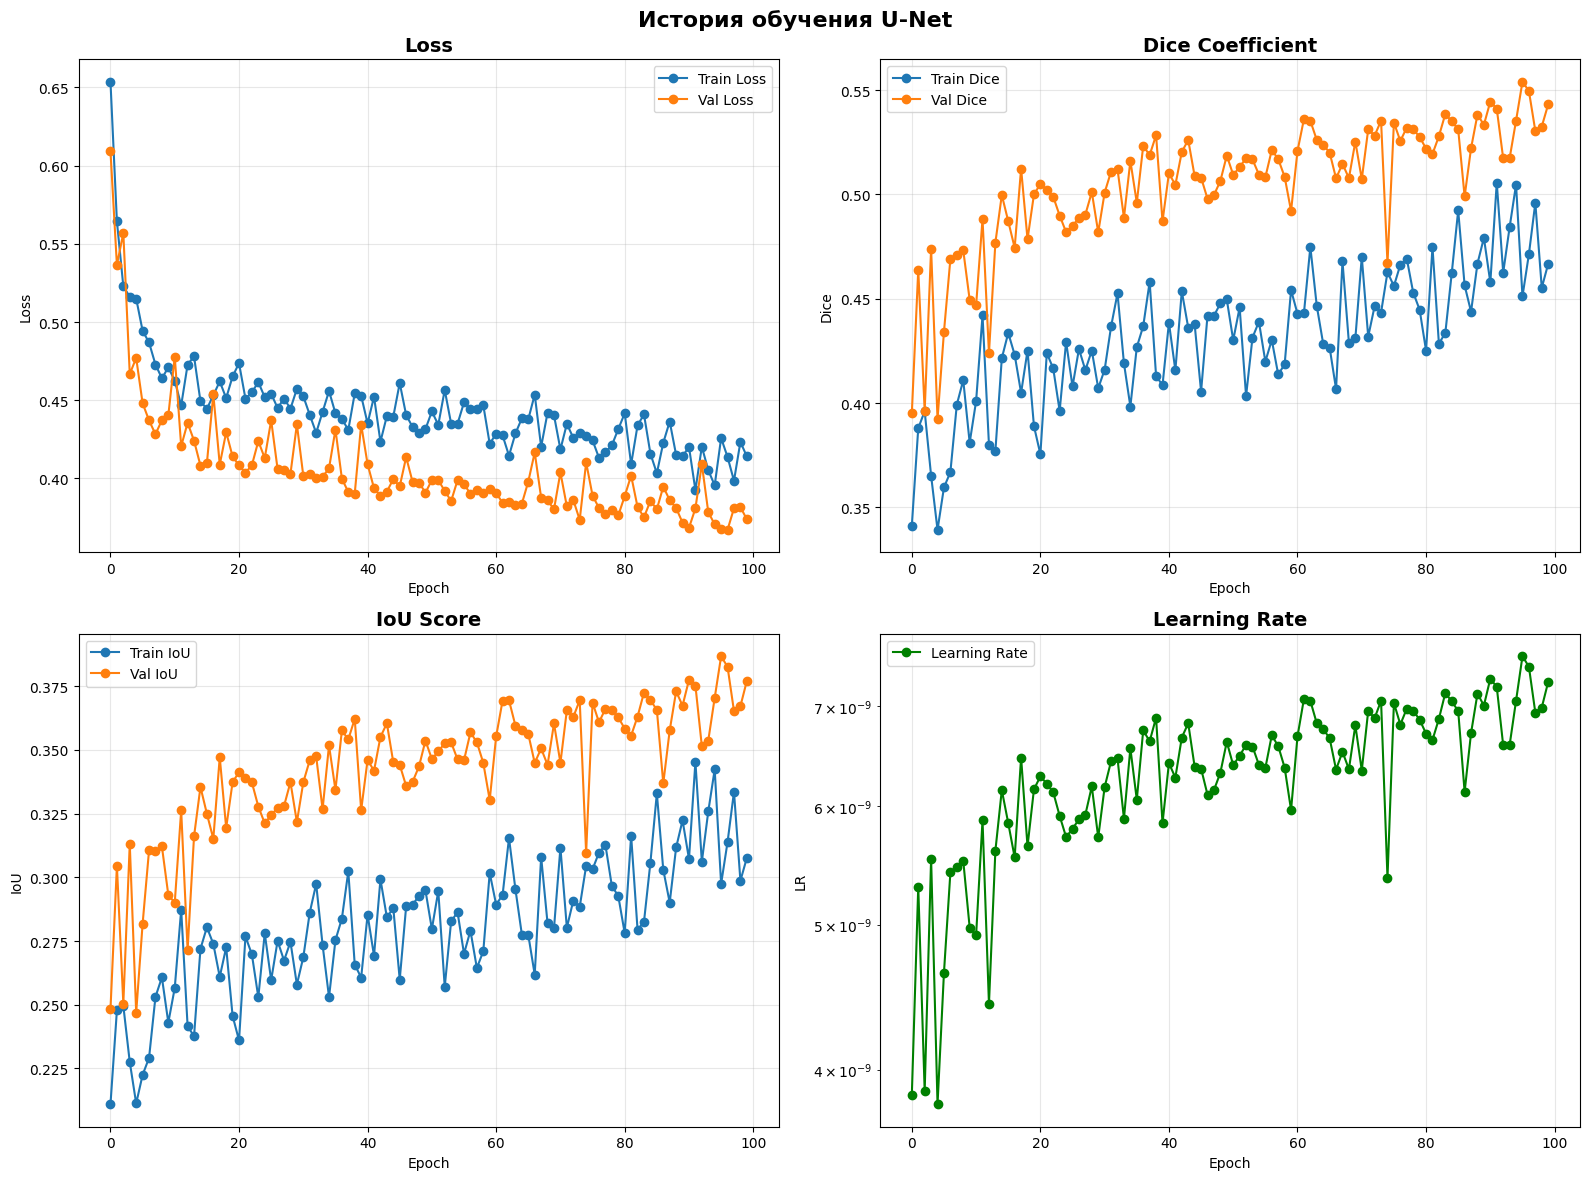

Train Loss: 0.4141
Val Loss: 0.3740
Train Dice: 0.4667
Val Dice: 0.5431
Train IoU: 0.3076
Val IoU: 0.3770
Val Accuracy: 0.9142


In [147]:
plot_training_history(my_history_freeze_all)


In [148]:
best_resnet_model = MyUNetFreeze_SimpleResNet32B(
    num_classes_backbone=10,
    ckpt_path="best_model.pth",
    out_channels=1,
    freeze_all=True,
    device=device
).to(device)


checkpoint = torch.load(SAVE_PATH_FREEZE_ALL, map_location=device)
best_resnet_model.load_state_dict(checkpoint['model_state_dict'])
best_resnet_model = best_resnet_model.to(device)

print(f"   Best epoch: {checkpoint['epoch']}")
print(f"   Best val Dice: {checkpoint['val_dice']:.4f}")


   Best epoch: 95
   Best val Dice: 0.5540


In [149]:
visualize_predictions(best_resnet_model, val_loader, device, num_samples=4)

#### Вариант B


In [150]:
my_model_finetune = MyUNetFreeze_SimpleResNet32B(
    num_classes_backbone=10,
    ckpt_path="best_model.pth",      
    out_channels=1,
    freeze_all=False,                
    device=device
).to(device)

my_model_criterion = CombinedLoss(bce_weight=0.5, dice_weight=0.5)

encoder_params = []
decoder_params = []

for name, param in my_model_finetune.named_parameters():
    if name.startswith("encoder") or name.startswith("backbone") or name.startswith("pool"):
        param.requires_grad = True   # на всякий случай
        encoder_params.append(param)
    else:
        decoder_params.append(param)

# Вариант B: encoder обучаем с меньшим LR, decoder — с большим
my_optimizer = torch.optim.Adam([
    {'params': [p for p in encoder_params if p.requires_grad], 'lr': 1e-4},  # encoder fine-tuning
    {'params': [p for p in decoder_params if p.requires_grad], 'lr': 1e-3},  # decoder
])

# Проверки
n_enc = sum(p.numel() for p in encoder_params)
n_dec = sum(p.numel() for p in decoder_params)
n_train = sum(p.numel() for p in my_model_finetune.parameters() if p.requires_grad)

print(f"Всего encoder params: {n_enc:,}")
print(f"Всего decoder params: {n_dec:,}")
print(f"Trainable params (должны быть > 0): {n_train:,}")
assert n_train > 0, "У модели нет обучаемых параметров — optimizer будет делать 'ничего'."

my_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    my_optimizer,
    T_0=10,
    T_mult=2,
    eta_min=1e-6
)

NUM_EPOCHS_FINETUNE = 100
SAVE_PATH_FINETUNE = "best_unet_backbone_finetune.pth"

print(f"   Эпох: {NUM_EPOCHS_FINETUNE}")
print(f"   Encoder LR: 1e-4 (fine-tuning)")
print(f"   Decoder LR: 1e-3")
print(f"   Модель будет сохранена в: {SAVE_PATH_FINETUNE}")

my_history_finetune = train_model(
    model=my_model_finetune,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=my_model_criterion,
    optimizer=my_optimizer,
    scheduler=my_scheduler,
    num_epochs=NUM_EPOCHS_FINETUNE,
    device=device,
    save_path=SAVE_PATH_FINETUNE
)


Всего encoder params: 2,779,850
Всего decoder params: 6,681,153
Trainable params (должны быть > 0): 9,461,003
   Эпох: 100
   Encoder LR: 1e-4 (fine-tuning)
   Decoder LR: 1e-3
   Модель будет сохранена в: best_unet_backbone_finetune.pth
Эпоха 1/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.50it/s, loss=0.7484, dice=0.2990, iou=0.1757, acc=0.6596]



 Результаты эпохи 1:
  Train - Loss: 0.6739, Dice: 0.3013, IoU: 0.1824
  Val   - Loss: 0.7589, Dice: 0.2985, IoU: 0.1778, Acc: 0.6330
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.2985
Эпоха 2/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.42it/s, loss=0.5648, dice=0.4199, iou=0.2657, acc=0.8461]



 Результаты эпохи 2:
  Train - Loss: 0.5797, Dice: 0.3548, IoU: 0.2204
  Val   - Loss: 0.5880, Dice: 0.4053, IoU: 0.2564, Acc: 0.8211
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.4053
Эпоха 3/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.08it/s, loss=0.5000, dice=0.4062, iou=0.2549, acc=0.9210]



 Результаты эпохи 3:
  Train - Loss: 0.5386, Dice: 0.3580, IoU: 0.2233
  Val   - Loss: 0.4995, Dice: 0.4424, IoU: 0.2856, Acc: 0.9152
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.4424
Эпоха 4/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.32it/s, loss=0.4689, dice=0.4355, iou=0.2784, acc=0.8952]



 Результаты эпохи 4:
  Train - Loss: 0.5063, Dice: 0.4088, IoU: 0.2600
  Val   - Loss: 0.4642, Dice: 0.4689, IoU: 0.3090, Acc: 0.8867
  LR: 0.000099
  Сохранена лучшая модель! Dice: 0.4689
Эпоха 5/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.32it/s, loss=0.4603, dice=0.4593, iou=0.2981, acc=0.9038]



 Результаты эпохи 5:
  Train - Loss: 0.4923, Dice: 0.3967, IoU: 0.2507
  Val   - Loss: 0.4529, Dice: 0.4887, IoU: 0.3266, Acc: 0.8975
  LR: 0.000099
  Сохранена лучшая модель! Dice: 0.4887
Эпоха 6/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.24it/s, loss=0.4424, dice=0.4589, iou=0.2978, acc=0.9143]



 Результаты эпохи 6:
  Train - Loss: 0.4737, Dice: 0.4114, IoU: 0.2663
  Val   - Loss: 0.4400, Dice: 0.4809, IoU: 0.3192, Acc: 0.9059
  LR: 0.000099
Эпоха 7/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.44it/s, loss=0.4431, dice=0.4888, iou=0.3235, acc=0.8986]



 Результаты эпохи 7:
  Train - Loss: 0.4799, Dice: 0.3866, IoU: 0.2455
  Val   - Loss: 0.4669, Dice: 0.4603, IoU: 0.3027, Acc: 0.8681
  LR: 0.000099
Эпоха 8/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.45it/s, loss=0.4791, dice=0.4443, iou=0.2856, acc=0.8926]



 Результаты эпохи 8:
  Train - Loss: 0.4780, Dice: 0.3921, IoU: 0.2481
  Val   - Loss: 0.4627, Dice: 0.4703, IoU: 0.3095, Acc: 0.8976
  LR: 0.000099
Эпоха 9/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.39it/s, loss=0.4383, dice=0.4277, iou=0.2720, acc=0.9203]



 Результаты эпохи 9:
  Train - Loss: 0.4635, Dice: 0.4110, IoU: 0.2633
  Val   - Loss: 0.4236, Dice: 0.4716, IoU: 0.3135, Acc: 0.9115
  LR: 0.000099
Эпоха 10/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.44it/s, loss=0.4720, dice=0.4463, iou=0.2873, acc=0.8580]



 Результаты эпохи 10:
  Train - Loss: 0.4740, Dice: 0.3976, IoU: 0.2534
  Val   - Loss: 0.4898, Dice: 0.4379, IoU: 0.2833, Acc: 0.8420
  LR: 0.000100
Эпоха 11/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.52it/s, loss=0.4194, dice=0.4578, iou=0.2969, acc=0.9163]



 Результаты эпохи 11:
  Train - Loss: 0.4727, Dice: 0.3820, IoU: 0.2413
  Val   - Loss: 0.4130, Dice: 0.4988, IoU: 0.3357, Acc: 0.9124
  LR: 0.000099
  Сохранена лучшая модель! Dice: 0.4988
Эпоха 12/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.61it/s, loss=0.4718, dice=0.3109, iou=0.1841, acc=0.9218]



 Результаты эпохи 12:
  Train - Loss: 0.4610, Dice: 0.4000, IoU: 0.2559
  Val   - Loss: 0.4579, Dice: 0.3813, IoU: 0.2406, Acc: 0.9129
  LR: 0.000100
Эпоха 13/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.65it/s, loss=0.4079, dice=0.4706, iou=0.3077, acc=0.9193]



 Результаты эпохи 13:
  Train - Loss: 0.4635, Dice: 0.3932, IoU: 0.2482
  Val   - Loss: 0.4058, Dice: 0.4974, IoU: 0.3338, Acc: 0.9122
  LR: 0.000099
Эпоха 14/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.27it/s, loss=0.4417, dice=0.4226, iou=0.2679, acc=0.9240]



 Результаты эпохи 14:
  Train - Loss: 0.4427, Dice: 0.4374, IoU: 0.2863
  Val   - Loss: 0.4300, Dice: 0.4679, IoU: 0.3073, Acc: 0.9203
  LR: 0.000099
Эпоха 15/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.53it/s, loss=0.4374, dice=0.4601, iou=0.2988, acc=0.8803]



 Результаты эпохи 15:
  Train - Loss: 0.4623, Dice: 0.4016, IoU: 0.2552
  Val   - Loss: 0.4297, Dice: 0.4897, IoU: 0.3279, Acc: 0.8847
  LR: 0.000099
Эпоха 16/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.39it/s, loss=0.4112, dice=0.4759, iou=0.3123, acc=0.9110]



 Результаты эпохи 16:
  Train - Loss: 0.4686, Dice: 0.3972, IoU: 0.2521
  Val   - Loss: 0.4147, Dice: 0.4956, IoU: 0.3333, Acc: 0.8994
  LR: 0.000099
Эпоха 17/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.25it/s, loss=0.3881, dice=0.5033, iou=0.3363, acc=0.9230]



 Результаты эпохи 17:
  Train - Loss: 0.4364, Dice: 0.4483, IoU: 0.2916
  Val   - Loss: 0.3945, Dice: 0.5151, IoU: 0.3505, Acc: 0.9147
  LR: 0.000099
  Сохранена лучшая модель! Dice: 0.5151
Эпоха 18/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.14it/s, loss=0.4352, dice=0.4022, iou=0.2517, acc=0.9232]



 Результаты эпохи 18:
  Train - Loss: 0.4669, Dice: 0.3937, IoU: 0.2495
  Val   - Loss: 0.4206, Dice: 0.4603, IoU: 0.3019, Acc: 0.9188
  LR: 0.000099
Эпоха 19/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.13it/s, loss=0.4229, dice=0.4207, iou=0.2664, acc=0.9214]



 Результаты эпохи 19:
  Train - Loss: 0.4325, Dice: 0.4567, IoU: 0.2988
  Val   - Loss: 0.4175, Dice: 0.4625, IoU: 0.3059, Acc: 0.9092
  LR: 0.000099
Эпоха 20/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.36it/s, loss=0.3974, dice=0.4979, iou=0.3315, acc=0.9198]



 Результаты эпохи 20:
  Train - Loss: 0.4528, Dice: 0.4079, IoU: 0.2594
  Val   - Loss: 0.4019, Dice: 0.5091, IoU: 0.3446, Acc: 0.9123
  LR: 0.000099
Эпоха 21/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.28it/s, loss=0.4089, dice=0.4588, iou=0.2977, acc=0.9170]



 Результаты эпохи 21:
  Train - Loss: 0.4605, Dice: 0.4008, IoU: 0.2552
  Val   - Loss: 0.4106, Dice: 0.4881, IoU: 0.3277, Acc: 0.9070
  LR: 0.000099
Эпоха 22/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.21it/s, loss=0.4023, dice=0.4813, iou=0.3169, acc=0.9218]



 Результаты эпохи 22:
  Train - Loss: 0.4440, Dice: 0.4351, IoU: 0.2823
  Val   - Loss: 0.4015, Dice: 0.5016, IoU: 0.3379, Acc: 0.9148
  LR: 0.000099
Эпоха 23/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.40it/s, loss=0.4237, dice=0.4203, iou=0.2661, acc=0.9188]



 Результаты эпохи 23:
  Train - Loss: 0.4432, Dice: 0.4431, IoU: 0.2889
  Val   - Loss: 0.4153, Dice: 0.4801, IoU: 0.3208, Acc: 0.9117
  LR: 0.000099
Эпоха 24/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.22it/s, loss=0.4037, dice=0.4539, iou=0.2936, acc=0.9224]



 Результаты эпохи 24:
  Train - Loss: 0.4423, Dice: 0.4260, IoU: 0.2750
  Val   - Loss: 0.3989, Dice: 0.4989, IoU: 0.3368, Acc: 0.9154
  LR: 0.000099
Эпоха 25/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.36it/s, loss=0.4013, dice=0.4769, iou=0.3131, acc=0.9227]



 Результаты эпохи 25:
  Train - Loss: 0.4419, Dice: 0.4307, IoU: 0.2793
  Val   - Loss: 0.4021, Dice: 0.5043, IoU: 0.3411, Acc: 0.9150
  LR: 0.000099
Эпоха 26/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.44it/s, loss=0.3857, dice=0.5092, iou=0.3416, acc=0.9224]



 Результаты эпохи 26:
  Train - Loss: 0.4427, Dice: 0.4317, IoU: 0.2806
  Val   - Loss: 0.3966, Dice: 0.5125, IoU: 0.3478, Acc: 0.9073
  LR: 0.000099
Эпоха 27/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.25it/s, loss=0.4128, dice=0.4560, iou=0.2953, acc=0.9037]



 Результаты эпохи 27:
  Train - Loss: 0.4382, Dice: 0.4419, IoU: 0.2884
  Val   - Loss: 0.4162, Dice: 0.4887, IoU: 0.3280, Acc: 0.8966
  LR: 0.000099
Эпоха 28/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.43it/s, loss=0.4009, dice=0.4634, iou=0.3015, acc=0.9202]



 Результаты эпохи 28:
  Train - Loss: 0.4400, Dice: 0.4342, IoU: 0.2815
  Val   - Loss: 0.4076, Dice: 0.4850, IoU: 0.3245, Acc: 0.9061
  LR: 0.000099
Эпоха 29/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.23it/s, loss=0.3927, dice=0.4804, iou=0.3162, acc=0.9139]



 Результаты эпохи 29:
  Train - Loss: 0.4358, Dice: 0.4404, IoU: 0.2897
  Val   - Loss: 0.3932, Dice: 0.5133, IoU: 0.3495, Acc: 0.9086
  LR: 0.000099
Эпоха 30/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.31it/s, loss=0.3898, dice=0.4845, iou=0.3197, acc=0.9226]



 Результаты эпохи 30:
  Train - Loss: 0.4495, Dice: 0.4173, IoU: 0.2698
  Val   - Loss: 0.3917, Dice: 0.5132, IoU: 0.3497, Acc: 0.9144
  LR: 0.000099
Эпоха 31/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.22it/s, loss=0.3745, dice=0.5015, iou=0.3347, acc=0.9182]



 Результаты эпохи 31:
  Train - Loss: 0.4255, Dice: 0.4543, IoU: 0.2982
  Val   - Loss: 0.3957, Dice: 0.5085, IoU: 0.3453, Acc: 0.9079
  LR: 0.000099
Эпоха 32/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.28it/s, loss=0.4129, dice=0.4452, iou=0.2863, acc=0.9261]



 Результаты эпохи 32:
  Train - Loss: 0.4377, Dice: 0.4372, IoU: 0.2865
  Val   - Loss: 0.4032, Dice: 0.4824, IoU: 0.3222, Acc: 0.9192
  LR: 0.000099
Эпоха 33/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.20it/s, loss=0.3836, dice=0.4991, iou=0.3325, acc=0.9184]



 Результаты эпохи 33:
  Train - Loss: 0.4461, Dice: 0.4191, IoU: 0.2713
  Val   - Loss: 0.3888, Dice: 0.5225, IoU: 0.3582, Acc: 0.9097
  LR: 0.000099
  Сохранена лучшая модель! Dice: 0.5225
Эпоха 34/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.26it/s, loss=0.3973, dice=0.4581, iou=0.2971, acc=0.9244]



 Результаты эпохи 34:
  Train - Loss: 0.4435, Dice: 0.4254, IoU: 0.2757
  Val   - Loss: 0.3916, Dice: 0.5051, IoU: 0.3419, Acc: 0.9187
  LR: 0.000099
Эпоха 35/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.49it/s, loss=0.4024, dice=0.4467, iou=0.2876, acc=0.9269]



 Результаты эпохи 35:
  Train - Loss: 0.4357, Dice: 0.4477, IoU: 0.2925
  Val   - Loss: 0.3952, Dice: 0.5008, IoU: 0.3403, Acc: 0.9184
  LR: 0.000099
Эпоха 36/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.25it/s, loss=0.4013, dice=0.4529, iou=0.2928, acc=0.9202]



 Результаты эпохи 36:
  Train - Loss: 0.4385, Dice: 0.4402, IoU: 0.2889
  Val   - Loss: 0.3955, Dice: 0.4966, IoU: 0.3360, Acc: 0.9149
  LR: 0.000099
Эпоха 37/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.36it/s, loss=0.3785, dice=0.5024, iou=0.3355, acc=0.9282]



 Результаты эпохи 37:
  Train - Loss: 0.4285, Dice: 0.4513, IoU: 0.2957
  Val   - Loss: 0.3819, Dice: 0.5263, IoU: 0.3616, Acc: 0.9204
  LR: 0.000099
  Сохранена лучшая модель! Dice: 0.5263
Эпоха 38/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.38it/s, loss=0.3812, dice=0.5207, iou=0.3520, acc=0.9214]



 Результаты эпохи 38:
  Train - Loss: 0.4423, Dice: 0.4186, IoU: 0.2688
  Val   - Loss: 0.3898, Dice: 0.5344, IoU: 0.3676, Acc: 0.9160
  LR: 0.000099
  Сохранена лучшая модель! Dice: 0.5344
Эпоха 39/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.14it/s, loss=0.3984, dice=0.4575, iou=0.2966, acc=0.9199]



 Результаты эпохи 39:
  Train - Loss: 0.4483, Dice: 0.4211, IoU: 0.2730
  Val   - Loss: 0.3968, Dice: 0.4900, IoU: 0.3309, Acc: 0.9140
  LR: 0.000099
Эпоха 40/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.16it/s, loss=0.3826, dice=0.5028, iou=0.3359, acc=0.9240]



 Результаты эпохи 40:
  Train - Loss: 0.4347, Dice: 0.4347, IoU: 0.2845
  Val   - Loss: 0.3851, Dice: 0.5236, IoU: 0.3593, Acc: 0.9170
  LR: 0.000099
Эпоха 41/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.36it/s, loss=0.4222, dice=0.4196, iou=0.2655, acc=0.9221]



 Результаты эпохи 41:
  Train - Loss: 0.4461, Dice: 0.4243, IoU: 0.2713
  Val   - Loss: 0.4020, Dice: 0.4831, IoU: 0.3239, Acc: 0.9196
  LR: 0.000099
Эпоха 42/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.02it/s, loss=0.3696, dice=0.5213, iou=0.3525, acc=0.9207]



 Результаты эпохи 42:
  Train - Loss: 0.4404, Dice: 0.4228, IoU: 0.2705
  Val   - Loss: 0.3856, Dice: 0.5282, IoU: 0.3632, Acc: 0.9077
  LR: 0.000099
Эпоха 43/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.36it/s, loss=0.3735, dice=0.5255, iou=0.3564, acc=0.9177]



 Результаты эпохи 43:
  Train - Loss: 0.4374, Dice: 0.4416, IoU: 0.2897
  Val   - Loss: 0.3870, Dice: 0.5311, IoU: 0.3658, Acc: 0.9131
  LR: 0.000099
Эпоха 44/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.01it/s, loss=0.4282, dice=0.3794, iou=0.2341, acc=0.9238]



 Результаты эпохи 44:
  Train - Loss: 0.4462, Dice: 0.4218, IoU: 0.2744
  Val   - Loss: 0.4107, Dice: 0.4525, IoU: 0.2968, Acc: 0.9211
  LR: 0.000100
Эпоха 45/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.21it/s, loss=0.3782, dice=0.5027, iou=0.3358, acc=0.9176]



 Результаты эпохи 45:
  Train - Loss: 0.4170, Dice: 0.4686, IoU: 0.3098
  Val   - Loss: 0.3792, Dice: 0.5347, IoU: 0.3700, Acc: 0.9139
  LR: 0.000099
  Сохранена лучшая модель! Dice: 0.5347
Эпоха 46/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.03it/s, loss=0.3832, dice=0.4833, iou=0.3186, acc=0.9253]



 Результаты эпохи 46:
  Train - Loss: 0.4207, Dice: 0.4584, IoU: 0.3042
  Val   - Loss: 0.3763, Dice: 0.5219, IoU: 0.3580, Acc: 0.9201
  LR: 0.000099
Эпоха 47/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.26it/s, loss=0.4064, dice=0.4392, iou=0.2814, acc=0.9244]



 Результаты эпохи 47:
  Train - Loss: 0.4098, Dice: 0.4851, IoU: 0.3277
  Val   - Loss: 0.3905, Dice: 0.4996, IoU: 0.3379, Acc: 0.9215
  LR: 0.000099
Эпоха 48/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.30it/s, loss=0.3722, dice=0.5123, iou=0.3444, acc=0.9256]



 Результаты эпохи 48:
  Train - Loss: 0.4214, Dice: 0.4598, IoU: 0.3031
  Val   - Loss: 0.3739, Dice: 0.5379, IoU: 0.3715, Acc: 0.9212
  LR: 0.000099
  Сохранена лучшая модель! Dice: 0.5379
Эпоха 49/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.19it/s, loss=0.3885, dice=0.4954, iou=0.3293, acc=0.9231]



 Результаты эпохи 49:
  Train - Loss: 0.4125, Dice: 0.4803, IoU: 0.3227
  Val   - Loss: 0.3906, Dice: 0.5219, IoU: 0.3572, Acc: 0.9170
  LR: 0.000099
Эпоха 50/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.29it/s, loss=0.3660, dice=0.5247, iou=0.3557, acc=0.9305]



 Результаты эпохи 50:
  Train - Loss: 0.4215, Dice: 0.4680, IoU: 0.3109
  Val   - Loss: 0.3772, Dice: 0.5283, IoU: 0.3623, Acc: 0.9233
  LR: 0.000099
Эпоха 51/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.03it/s, loss=0.3680, dice=0.5055, iou=0.3383, acc=0.9276]



 Результаты эпохи 51:
  Train - Loss: 0.4317, Dice: 0.4403, IoU: 0.2880
  Val   - Loss: 0.3749, Dice: 0.5270, IoU: 0.3621, Acc: 0.9207
  LR: 0.000099
Эпоха 52/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.26it/s, loss=0.3933, dice=0.4705, iou=0.3076, acc=0.9265]



 Результаты эпохи 52:
  Train - Loss: 0.4229, Dice: 0.4636, IoU: 0.3056
  Val   - Loss: 0.3809, Dice: 0.5225, IoU: 0.3575, Acc: 0.9229
  LR: 0.000099
Эпоха 53/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.17it/s, loss=0.3600, dice=0.5351, iou=0.3652, acc=0.9269]



 Результаты эпохи 53:
  Train - Loss: 0.4229, Dice: 0.4555, IoU: 0.2995
  Val   - Loss: 0.3716, Dice: 0.5479, IoU: 0.3810, Acc: 0.9176
  LR: 0.000099
  Сохранена лучшая модель! Dice: 0.5479
Эпоха 54/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.39it/s, loss=0.4277, dice=0.4161, iou=0.2627, acc=0.9250]



 Результаты эпохи 54:
  Train - Loss: 0.4322, Dice: 0.4356, IoU: 0.2857
  Val   - Loss: 0.4105, Dice: 0.4751, IoU: 0.3193, Acc: 0.9175
  LR: 0.000099
Эпоха 55/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.10it/s, loss=0.3846, dice=0.5118, iou=0.3439, acc=0.9170]



 Результаты эпохи 55:
  Train - Loss: 0.4237, Dice: 0.4625, IoU: 0.3027
  Val   - Loss: 0.3982, Dice: 0.5226, IoU: 0.3582, Acc: 0.9020
  LR: 0.000099
Эпоха 56/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.17it/s, loss=0.3786, dice=0.5160, iou=0.3477, acc=0.9147]



 Результаты эпохи 56:
  Train - Loss: 0.4290, Dice: 0.4526, IoU: 0.2955
  Val   - Loss: 0.3866, Dice: 0.5327, IoU: 0.3668, Acc: 0.8999
  LR: 0.000099
Эпоха 57/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.06it/s, loss=0.4261, dice=0.4001, iou=0.2501, acc=0.9218]



 Результаты эпохи 57:
  Train - Loss: 0.4169, Dice: 0.4759, IoU: 0.3160
  Val   - Loss: 0.3912, Dice: 0.4988, IoU: 0.3402, Acc: 0.9194
  LR: 0.000099
Эпоха 58/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.02it/s, loss=0.3880, dice=0.4846, iou=0.3198, acc=0.9275]



 Результаты эпохи 58:
  Train - Loss: 0.4314, Dice: 0.4491, IoU: 0.2965
  Val   - Loss: 0.3730, Dice: 0.5327, IoU: 0.3665, Acc: 0.9245
  LR: 0.000099
Эпоха 59/100


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.80it/s, loss=0.4259, dice=0.3979, iou=0.2484, acc=0.9231]



 Результаты эпохи 59:
  Train - Loss: 0.4345, Dice: 0.4435, IoU: 0.2939
  Val   - Loss: 0.3922, Dice: 0.4859, IoU: 0.3271, Acc: 0.9238
  LR: 0.000099
Эпоха 60/100


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.86it/s, loss=0.3897, dice=0.5092, iou=0.3416, acc=0.9272]



 Результаты эпохи 60:
  Train - Loss: 0.4319, Dice: 0.4484, IoU: 0.2955
  Val   - Loss: 0.3869, Dice: 0.5300, IoU: 0.3631, Acc: 0.9202
  LR: 0.000099
Эпоха 61/100


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.88it/s, loss=0.4247, dice=0.4070, iou=0.2555, acc=0.9199]



 Результаты эпохи 61:
  Train - Loss: 0.4489, Dice: 0.4046, IoU: 0.2604
  Val   - Loss: 0.4010, Dice: 0.4803, IoU: 0.3238, Acc: 0.9171
  LR: 0.000099
Эпоха 62/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.31it/s, loss=0.4339, dice=0.3750, iou=0.2308, acc=0.9234]



 Результаты эпохи 62:
  Train - Loss: 0.4536, Dice: 0.4084, IoU: 0.2662
  Val   - Loss: 0.4090, Dice: 0.4560, IoU: 0.3005, Acc: 0.9214
  LR: 0.000099
Эпоха 63/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.17it/s, loss=0.3733, dice=0.5159, iou=0.3476, acc=0.9183]



 Результаты эпохи 63:
  Train - Loss: 0.4331, Dice: 0.4320, IoU: 0.2801
  Val   - Loss: 0.3767, Dice: 0.5368, IoU: 0.3716, Acc: 0.9124
  LR: 0.000099
Эпоха 64/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.31it/s, loss=0.4164, dice=0.4209, iou=0.2666, acc=0.9230]



 Результаты эпохи 64:
  Train - Loss: 0.4300, Dice: 0.4399, IoU: 0.2910
  Val   - Loss: 0.3821, Dice: 0.5054, IoU: 0.3440, Acc: 0.9227
  LR: 0.000099
Эпоха 65/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.30it/s, loss=0.3684, dice=0.5360, iou=0.3661, acc=0.9262]



 Результаты эпохи 65:
  Train - Loss: 0.4216, Dice: 0.4665, IoU: 0.3101
  Val   - Loss: 0.3747, Dice: 0.5469, IoU: 0.3814, Acc: 0.9168
  LR: 0.000099
Эпоха 66/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.12it/s, loss=0.3801, dice=0.4935, iou=0.3276, acc=0.9283]



 Результаты эпохи 66:
  Train - Loss: 0.3959, Dice: 0.5054, IoU: 0.3448
  Val   - Loss: 0.3734, Dice: 0.5282, IoU: 0.3632, Acc: 0.9227
  LR: 0.000099
Эпоха 67/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.05it/s, loss=0.3926, dice=0.4688, iou=0.3062, acc=0.9251]



 Результаты эпохи 67:
  Train - Loss: 0.4192, Dice: 0.4678, IoU: 0.3104
  Val   - Loss: 0.3813, Dice: 0.5175, IoU: 0.3559, Acc: 0.9201
  LR: 0.000099
Эпоха 68/100


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.93it/s, loss=0.3664, dice=0.5182, iou=0.3497, acc=0.9290]



 Результаты эпохи 68:
  Train - Loss: 0.4037, Dice: 0.4845, IoU: 0.3266
  Val   - Loss: 0.3724, Dice: 0.5345, IoU: 0.3699, Acc: 0.9200
  LR: 0.000099
Эпоха 69/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.06it/s, loss=0.3975, dice=0.4544, iou=0.2940, acc=0.9239]



 Результаты эпохи 69:
  Train - Loss: 0.3969, Dice: 0.4951, IoU: 0.3325
  Val   - Loss: 0.3800, Dice: 0.5250, IoU: 0.3612, Acc: 0.9179
  LR: 0.000099
Эпоха 70/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.07it/s, loss=0.3828, dice=0.4796, iou=0.3155, acc=0.9291]



 Результаты эпохи 70:
  Train - Loss: 0.4337, Dice: 0.4422, IoU: 0.2911
  Val   - Loss: 0.3777, Dice: 0.5255, IoU: 0.3619, Acc: 0.9240
  LR: 0.000099
Эпоха 71/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.28it/s, loss=0.3760, dice=0.5016, iou=0.3348, acc=0.9299]



 Результаты эпохи 71:
  Train - Loss: 0.4155, Dice: 0.4594, IoU: 0.3069
  Val   - Loss: 0.3763, Dice: 0.5310, IoU: 0.3664, Acc: 0.9237
  LR: 0.000099
Эпоха 72/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.30it/s, loss=0.3718, dice=0.5188, iou=0.3502, acc=0.9250]



 Результаты эпохи 72:
  Train - Loss: 0.4184, Dice: 0.4703, IoU: 0.3121
  Val   - Loss: 0.3731, Dice: 0.5409, IoU: 0.3749, Acc: 0.9202
  LR: 0.000099
Эпоха 73/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.15it/s, loss=0.3779, dice=0.5277, iou=0.3584, acc=0.9143]



 Результаты эпохи 73:
  Train - Loss: 0.4284, Dice: 0.4508, IoU: 0.2979
  Val   - Loss: 0.3904, Dice: 0.5324, IoU: 0.3674, Acc: 0.9050
  LR: 0.000099
Эпоха 74/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.38it/s, loss=0.3781, dice=0.4844, iou=0.3196, acc=0.9289]



 Результаты эпохи 74:
  Train - Loss: 0.4388, Dice: 0.4259, IoU: 0.2752
  Val   - Loss: 0.3733, Dice: 0.5268, IoU: 0.3625, Acc: 0.9242
  LR: 0.000099
Эпоха 75/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.30it/s, loss=0.3705, dice=0.5228, iou=0.3539, acc=0.9223]



 Результаты эпохи 75:
  Train - Loss: 0.4045, Dice: 0.4946, IoU: 0.3340
  Val   - Loss: 0.3759, Dice: 0.5388, IoU: 0.3741, Acc: 0.9160
  LR: 0.000099
Эпоха 76/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.11it/s, loss=0.3811, dice=0.5281, iou=0.3588, acc=0.9057]



 Результаты эпохи 76:
  Train - Loss: 0.3964, Dice: 0.4979, IoU: 0.3365
  Val   - Loss: 0.3874, Dice: 0.5344, IoU: 0.3698, Acc: 0.9013
  LR: 0.000099
Эпоха 77/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.09it/s, loss=0.4271, dice=0.3849, iou=0.2383, acc=0.9251]



 Результаты эпохи 77:
  Train - Loss: 0.4187, Dice: 0.4708, IoU: 0.3162
  Val   - Loss: 0.3967, Dice: 0.4753, IoU: 0.3185, Acc: 0.9242
  LR: 0.000099
Эпоха 78/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.30it/s, loss=0.3625, dice=0.5429, iou=0.3726, acc=0.9276]



 Результаты эпохи 78:
  Train - Loss: 0.4277, Dice: 0.4541, IoU: 0.3005
  Val   - Loss: 0.3673, Dice: 0.5534, IoU: 0.3863, Acc: 0.9203
  LR: 0.000099
  Сохранена лучшая модель! Dice: 0.5534
Эпоха 79/100


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.50it/s, loss=0.3829, dice=0.4827, iou=0.3181, acc=0.9283]



 Результаты эпохи 79:
  Train - Loss: 0.4155, Dice: 0.4648, IoU: 0.3110
  Val   - Loss: 0.3729, Dice: 0.5334, IoU: 0.3691, Acc: 0.9229
  LR: 0.000099
Эпоха 80/100


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.52it/s, loss=0.3646, dice=0.5410, iou=0.3708, acc=0.9237]



 Результаты эпохи 80:
  Train - Loss: 0.4326, Dice: 0.4468, IoU: 0.2948
  Val   - Loss: 0.3692, Dice: 0.5576, IoU: 0.3901, Acc: 0.9160
  LR: 0.000099
  Сохранена лучшая модель! Dice: 0.5576
Эпоха 81/100


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.60it/s, loss=0.3636, dice=0.5250, iou=0.3559, acc=0.9297]



 Результаты эпохи 81:
  Train - Loss: 0.4159, Dice: 0.4615, IoU: 0.3047
  Val   - Loss: 0.3616, Dice: 0.5563, IoU: 0.3903, Acc: 0.9219
  LR: 0.000099
Эпоха 82/100


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.26it/s, loss=0.3852, dice=0.4760, iou=0.3123, acc=0.9310]



 Результаты эпохи 82:
  Train - Loss: 0.4222, Dice: 0.4672, IoU: 0.3112
  Val   - Loss: 0.3703, Dice: 0.5241, IoU: 0.3585, Acc: 0.9275
  LR: 0.000099
Эпоха 83/100


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.37it/s, loss=0.3859, dice=0.5173, iou=0.3489, acc=0.9021]



 Результаты эпохи 83:
  Train - Loss: 0.4341, Dice: 0.4299, IoU: 0.2794
  Val   - Loss: 0.4045, Dice: 0.5188, IoU: 0.3550, Acc: 0.8863
  LR: 0.000099
Эпоха 84/100


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.61it/s, loss=0.3594, dice=0.5475, iou=0.3769, acc=0.9236]



 Результаты эпохи 84:
  Train - Loss: 0.4364, Dice: 0.4399, IoU: 0.2880
  Val   - Loss: 0.3680, Dice: 0.5537, IoU: 0.3872, Acc: 0.9163
  LR: 0.000099
Эпоха 85/100


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.50it/s, loss=0.3547, dice=0.5580, iou=0.3870, acc=0.9271]



 Результаты эпохи 85:
  Train - Loss: 0.4185, Dice: 0.4599, IoU: 0.3042
  Val   - Loss: 0.3606, Dice: 0.5675, IoU: 0.4008, Acc: 0.9194
  LR: 0.000099
  Сохранена лучшая модель! Dice: 0.5675
Эпоха 86/100


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.45it/s, loss=0.3726, dice=0.5087, iou=0.3411, acc=0.9303]



 Результаты эпохи 86:
  Train - Loss: 0.4186, Dice: 0.4636, IoU: 0.3081
  Val   - Loss: 0.3668, Dice: 0.5445, IoU: 0.3780, Acc: 0.9262
  LR: 0.000099
Эпоха 87/100


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.44it/s, loss=0.3632, dice=0.5302, iou=0.3607, acc=0.9243]



 Результаты эпохи 87:
  Train - Loss: 0.4071, Dice: 0.4784, IoU: 0.3207
  Val   - Loss: 0.3698, Dice: 0.5503, IoU: 0.3848, Acc: 0.9160
  LR: 0.000099
Эпоха 88/100


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.83it/s, loss=0.3658, dice=0.5309, iou=0.3614, acc=0.9306]



 Результаты эпохи 88:
  Train - Loss: 0.4259, Dice: 0.4563, IoU: 0.3019
  Val   - Loss: 0.3657, Dice: 0.5556, IoU: 0.3884, Acc: 0.9244
  LR: 0.000099
Эпоха 89/100


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.55it/s, loss=0.3509, dice=0.5567, iou=0.3857, acc=0.9280]



 Результаты эпохи 89:
  Train - Loss: 0.4166, Dice: 0.4664, IoU: 0.3125
  Val   - Loss: 0.3593, Dice: 0.5648, IoU: 0.3981, Acc: 0.9192
  LR: 0.000099
Эпоха 90/100


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.01it/s, loss=0.3786, dice=0.4792, iou=0.3151, acc=0.9300]



 Результаты эпохи 90:
  Train - Loss: 0.4045, Dice: 0.4907, IoU: 0.3291
  Val   - Loss: 0.3678, Dice: 0.5337, IoU: 0.3688, Acc: 0.9264
  LR: 0.000099
Эпоха 91/100


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.94it/s, loss=0.3441, dice=0.5910, iou=0.4194, acc=0.9290]



 Результаты эпохи 91:
  Train - Loss: 0.4097, Dice: 0.4822, IoU: 0.3254
  Val   - Loss: 0.3612, Dice: 0.5777, IoU: 0.4096, Acc: 0.9160
  LR: 0.000099
  Сохранена лучшая модель! Dice: 0.5777
Эпоха 92/100


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.95it/s, loss=0.3601, dice=0.5529, iou=0.3821, acc=0.9132]



 Результаты эпохи 92:
  Train - Loss: 0.4058, Dice: 0.4714, IoU: 0.3132
  Val   - Loss: 0.3781, Dice: 0.5507, IoU: 0.3840, Acc: 0.9033
  LR: 0.000099
Эпоха 93/100


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.95it/s, loss=0.3875, dice=0.4648, iou=0.3028, acc=0.9299]



 Результаты эпохи 93:
  Train - Loss: 0.4060, Dice: 0.4840, IoU: 0.3254
  Val   - Loss: 0.3636, Dice: 0.5407, IoU: 0.3753, Acc: 0.9280
  LR: 0.000099
Эпоха 94/100


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.72it/s, loss=0.3583, dice=0.5309, iou=0.3614, acc=0.9310]



 Результаты эпохи 94:
  Train - Loss: 0.4066, Dice: 0.4821, IoU: 0.3255
  Val   - Loss: 0.3569, Dice: 0.5650, IoU: 0.3983, Acc: 0.9255
  LR: 0.000099
Эпоха 95/100


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.79it/s, loss=0.3610, dice=0.5439, iou=0.3736, acc=0.9266]



 Результаты эпохи 95:
  Train - Loss: 0.3952, Dice: 0.5081, IoU: 0.3469
  Val   - Loss: 0.3609, Dice: 0.5631, IoU: 0.3970, Acc: 0.9202
  LR: 0.000099
Эпоха 96/100


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.76it/s, loss=0.3560, dice=0.5451, iou=0.3746, acc=0.9317]



 Результаты эпохи 96:
  Train - Loss: 0.3995, Dice: 0.4935, IoU: 0.3337
  Val   - Loss: 0.3568, Dice: 0.5540, IoU: 0.3880, Acc: 0.9269
  LR: 0.000099
Эпоха 97/100


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.64it/s, loss=0.3628, dice=0.5275, iou=0.3582, acc=0.9278]



 Результаты эпохи 97:
  Train - Loss: 0.3924, Dice: 0.5069, IoU: 0.3470
  Val   - Loss: 0.3620, Dice: 0.5558, IoU: 0.3903, Acc: 0.9207
  LR: 0.000099
Эпоха 98/100


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.68it/s, loss=0.3777, dice=0.5077, iou=0.3402, acc=0.9255]



 Результаты эпохи 98:
  Train - Loss: 0.4055, Dice: 0.4769, IoU: 0.3186
  Val   - Loss: 0.3653, Dice: 0.5500, IoU: 0.3837, Acc: 0.9199
  LR: 0.000099
Эпоха 99/100


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.67it/s, loss=0.3885, dice=0.4738, iou=0.3105, acc=0.9274]



 Результаты эпохи 99:
  Train - Loss: 0.4073, Dice: 0.4782, IoU: 0.3194
  Val   - Loss: 0.3726, Dice: 0.5272, IoU: 0.3638, Acc: 0.9195
  LR: 0.000099
Эпоха 100/100


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.87it/s, loss=0.3678, dice=0.5010, iou=0.3342, acc=0.9286]


 Результаты эпохи 100:
  Train - Loss: 0.4060, Dice: 0.4912, IoU: 0.3325
  Val   - Loss: 0.3643, Dice: 0.5500, IoU: 0.3834, Acc: 0.9223
  LR: 0.000099
Лучший Val Dice: 0.5777


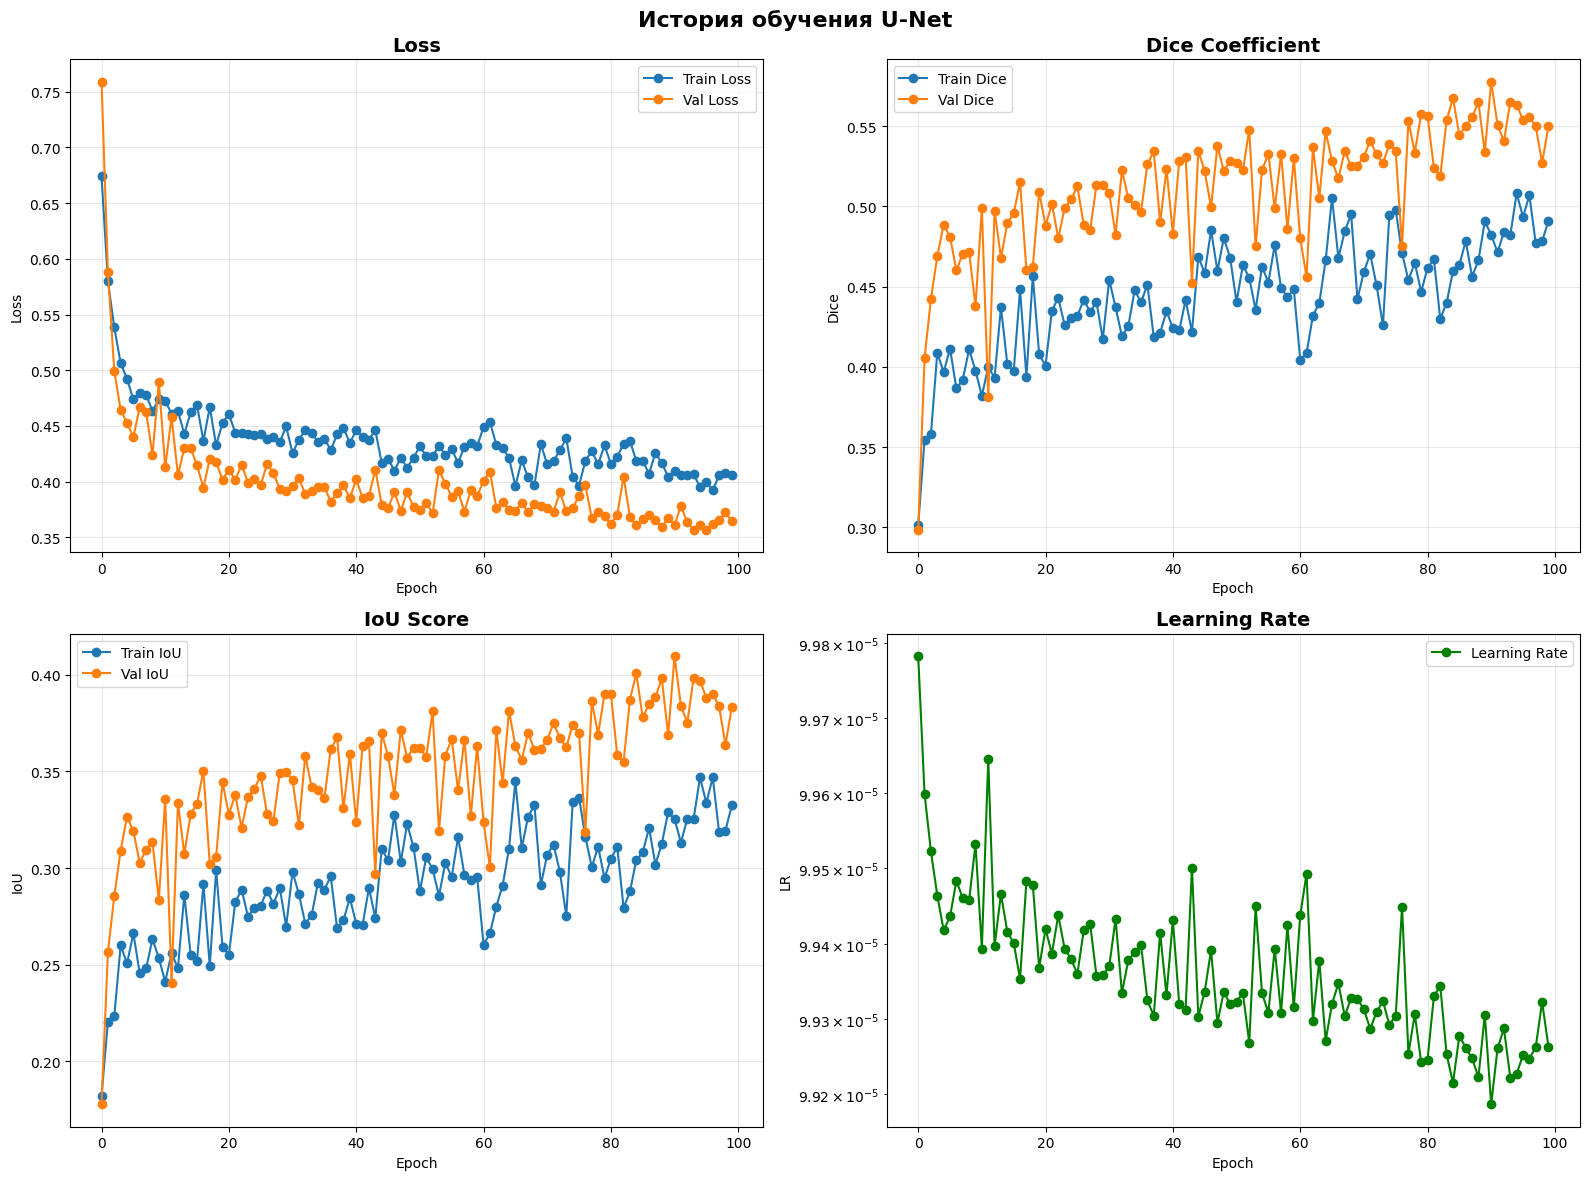

Train Loss: 0.4060
Val Loss: 0.3643
Train Dice: 0.4912
Val Dice: 0.5500
Train IoU: 0.3325
Val IoU: 0.3834
Val Accuracy: 0.9223


In [151]:
plot_training_history(my_history_finetune)


In [152]:
best_resnet_model = MyUNetFreeze_SimpleResNet32B(
    num_classes_backbone=10,
    ckpt_path="best_model.pth",      
    out_channels=1,
    freeze_all=False,                
    device=device
).to(device)


checkpoint = torch.load(SAVE_PATH_FINETUNE, map_location=device)
best_resnet_model.load_state_dict(checkpoint['model_state_dict'])
best_resnet_model = best_resnet_model.to(device)

print(f"   Best epoch: {checkpoint['epoch']}")
print(f"   Best val Dice: {checkpoint['val_dice']:.4f}")


   Best epoch: 90
   Best val Dice: 0.5777


In [153]:
visualize_predictions(best_resnet_model, val_loader, device, num_samples=4)

### Сравнение моделей 

In [ ]:
results = [
    {"Модель": "Base UNet", "Acc": '0.9', "Dice": '0.5', "IoU": '0.34', "Скорость сходимости": '82'},
    {"Модель": "3.1-A", "Acc": '0.91', "Dice": '0.55', "IoU": '0.39', "Скорость сходимости": '95'},
    {"Модель": "3.1-B", "Acc": '0.92', "Dice": '0.58', "IoU": '0.41', "Скорость сходимости": '90'},
]

df = pd.DataFrame(results)
df

Модель   Acc  Dice   IoU Скорость сходимости
0  Base UNet   0.9   0.5  0.34                  82
1      3.1-A  0.92  0.55  0.38                  93
2      3.1-B  0.92  0.57   0.4                  97

Использование энкодера из классификатора улучшает качество сегментации по сравнению с базовым U-Net. Вариант 3.1-B дает наилучшие результаты по метрикам